In [1]:
#import needed libraries (although not all imported below are used in the given code)

import os
from os import listdir
from os.path import isfile, join

import sys
import codecs
import fileinput
import string
from collections import OrderedDict

import numpy as np

from pandas import DataFrame
import pandas as pd

import matplotlib

%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.dates as md
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

#from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy import optimize, stats
from scipy.integrate import quad
from scipy.signal import find_peaks, peak_widths,hilbert

from decimal import Decimal



import iminuit 


import csv
import cmath
import math
from math import sqrt




# destination to the data (input) and output folders (change according to the path on your PC)

containing_folder_path = "/home/mfedkevych/Work/LZ/"
path_base = containing_folder_path + "code_backup/Analysis/AmBe-4_withW_withAttenuator_endcap_near/"
measurement_path= path_base +'Data/'
measurement_output_path= path_base + 'Results/'

#calibration parameters
#p0=1.234
#p1=1.1


p0=0.974
p1=1.1




#function to count number of significant digits after comma
def number_sigdigs(x):
    digs_after_comma = str(x - math.floor(x))
    digs_after_comma = digs_after_comma[2:]
    number=0
    for c in digs_after_comma:
        if c=='0':
            number+=1
        else:
            number+=2
            break
    return number

print('numpy version', np.__version__)
print('matplotlib version', matplotlib.__version__)
print('pandas version', pd.__version__)
print('scipy version', scipy.__version__)
print('iminuit version', iminuit.__version__)

numpy version 1.25.1
matplotlib version 3.7.2
pandas version 2.0.3
scipy version 1.11.1
iminuit version 2.22.0


In [2]:
# read the data files from measurement_path folder and replace "," delimiter with "."

files_in_folder = [f for f in listdir (measurement_path) if isfile(join(measurement_path, f))]
files_in_folder.sort()

for f in files_in_folder:
    
    name = 0

    # Read in the file
    with open(measurement_path+f, 'r') as input_file :
        filedata = input_file.read()

         # Replace the target string
        filedata = filedata.replace(",", ".")

    # Write the file out again
    with open(measurement_path+f, 'w') as input_file:
        input_file.write(filedata)
    input_file.close()

In [3]:
# read the data files and put the content into list of dataframes

numbers=np.linspace(0,8191,num=8192)
numbers=list(numbers)

import re

scan = [] #list of measurement data (in DataFrame format) extracted from scan files
files_scan=[] #list of measurement files

for f in files_in_folder:
    if "AmBe-4" in f: #choose only files with names containing "AmBe-1"
        
        print(f) #prints scan file name
        files_scan.append(f) 
        


        scan_temp = pd.read_csv(measurement_path + f, #read file content in DataFrame format
            skiprows=(0,1), 
            header=None,
            delimiter="\t",
            )
        print(scan_temp) #prints measurement file data in DataFrame format
        
        scan.append(scan_temp) # add the dataframe to the list

for f in files_in_folder:
    if "Background" in f: #choose only files with names containing "Background"
        
        print(f) #prints scan file name
        files_scan.append(f) 


        scan_temp = pd.read_csv(measurement_path + f, #read file content in DataFrame format
            skiprows=(0,1), 
            header=None,
            delimiter="\t",
            )
        print(scan_temp) #prints measurement file data in DataFrame format
        
        scan.append(scan_temp) # add the dataframe to the list

        

#combine background data
bkg = np.asarray(scan[1][1])+np.asarray(scan[2][1])+np.asarray(scan[3][1])+np.asarray(scan[4][1])

#AmBe measurement time and background measurement time
t=21097.8
t_bkg=3*86400+21211.939999999999


AmBe-4_on_endcap_to_endcap_in_capsule.dat
         0  1
0        0  0
1        1  0
2        2  0
3        3  0
4        4  0
...    ... ..
8187  8187  0
8188  8188  0
8189  8189  0
8190  8190  0
8191  8191  0

[8192 rows x 2 columns]
20230331_Background_00_000.dat
         0  1
0        0  0
1        1  0
2        2  0
3        3  0
4        4  0
...    ... ..
8187  8187  0
8188  8188  0
8189  8189  0
8190  8190  0
8191  8191  0

[8192 rows x 2 columns]
20230331_Background_00_001.dat
         0  1
0        0  0
1        1  0
2        2  0
3        3  0
4        4  0
...    ... ..
8187  8187  0
8188  8188  0
8189  8189  0
8190  8190  0
8191  8191  0

[8192 rows x 2 columns]
20230331_Background_00_002.dat
         0  1
0        0  0
1        1  0
2        2  0
3        3  0
4        4  0
...    ... ..
8187  8187  0
8188  8188  0
8189  8189  0
8190  8190  0
8191  8191  0

[8192 rows x 2 columns]
20230331_Background_00_003.dat
         0  1
0        0  0
1        1  0
2        2  0
3     

In [4]:
#checking that the scan files have been read and written in the right order

i=0
while i<len(files_scan):
    print(i, files_scan[i])
    i+=1


0 AmBe-4_on_endcap_to_endcap_in_capsule.dat
1 20230331_Background_00_000.dat
2 20230331_Background_00_001.dat
3 20230331_Background_00_002.dat
4 20230331_Background_00_003.dat


<Figure size 1700x1400 with 0 Axes>

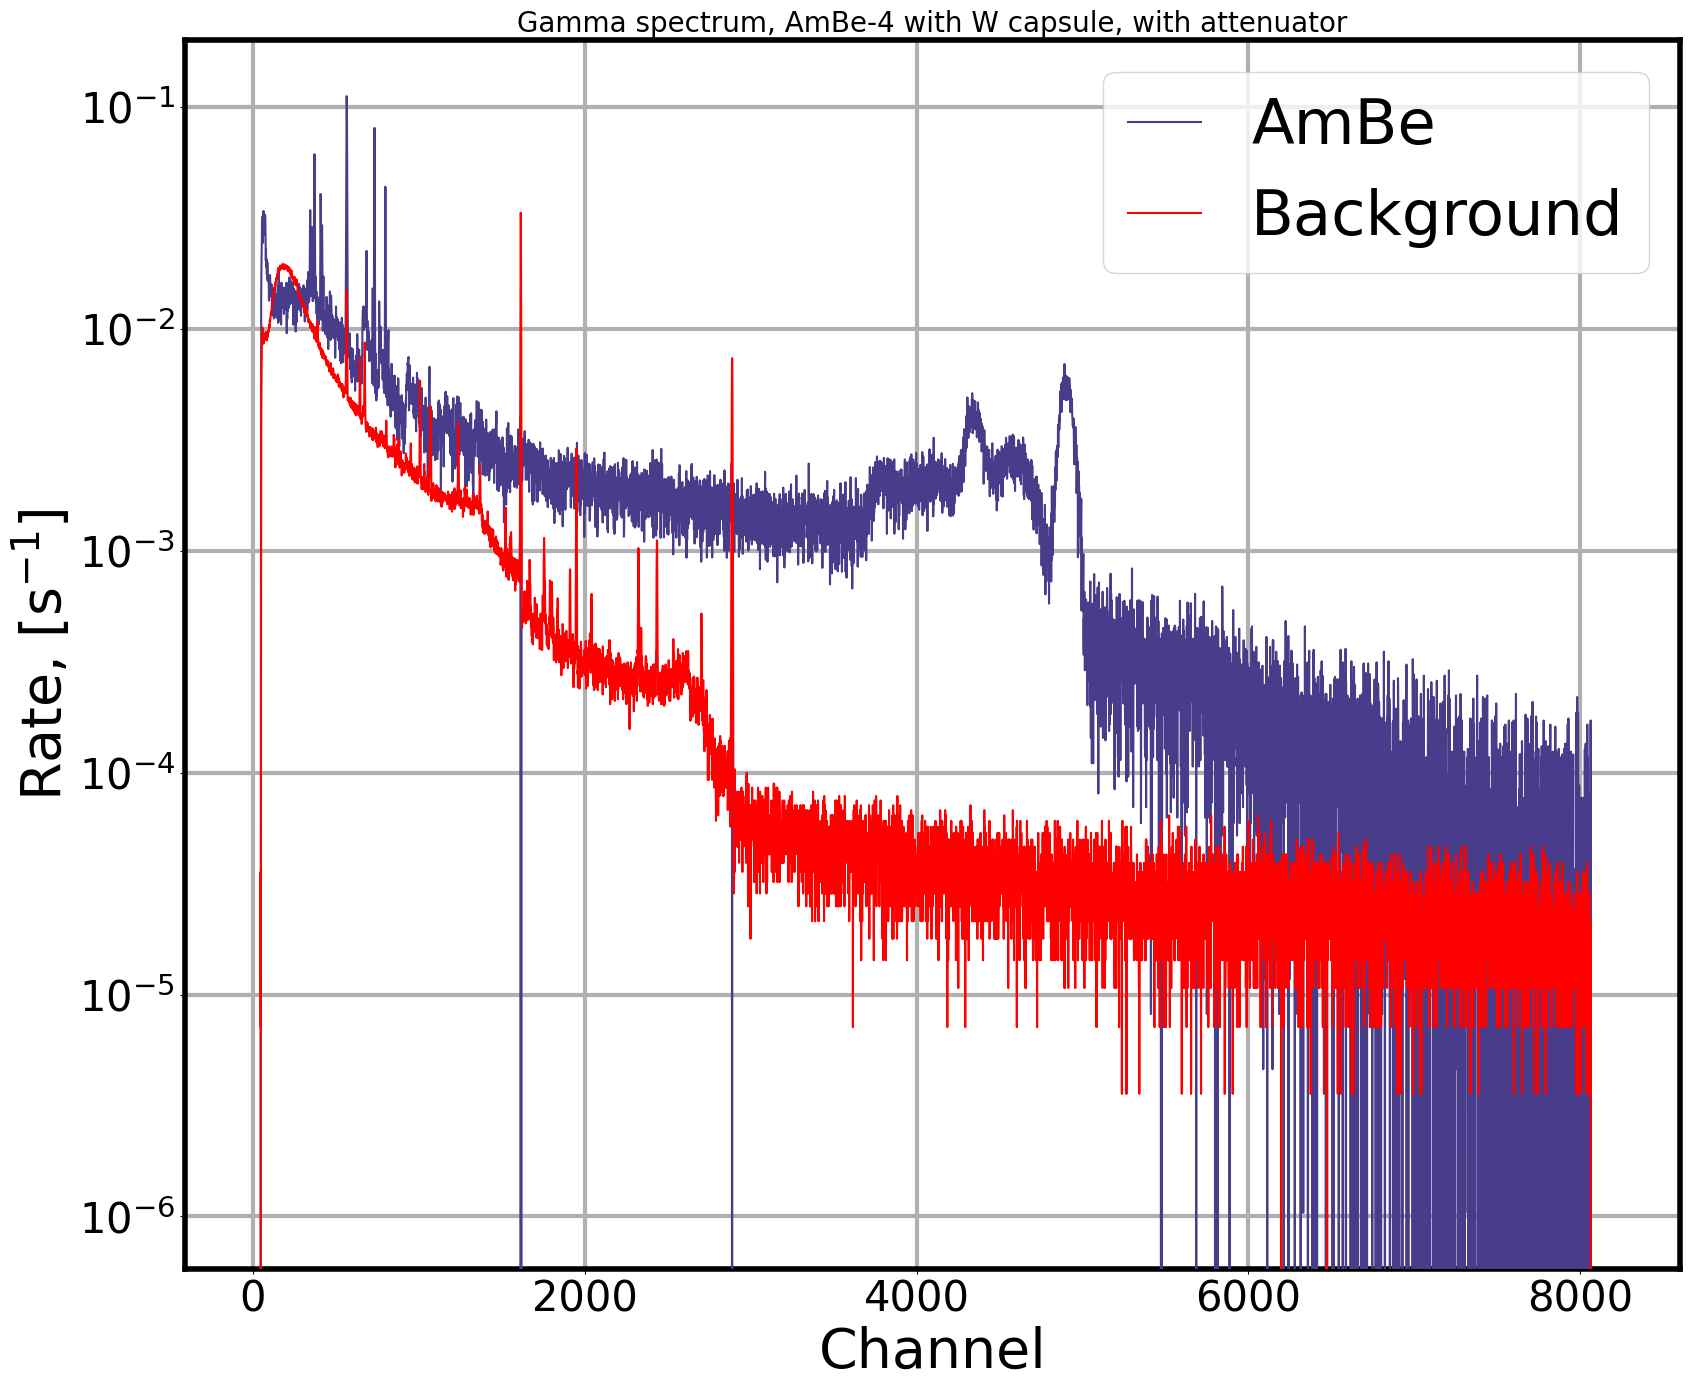

In [5]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65



plt.figure()
fig, ax1 = plt.subplots()

plt.title('Gamma spectrum, AmBe-4 with W capsule, with attenuator', fontsize=20)

#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Rate, [s$^{-1}$]", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)

for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)





Data = ax1.plot(np.asarray(scan[0][0]), np.asarray(scan[0][1])/t - (np.asarray(bkg))/t_bkg, 
                          color="darkslateblue", label="AmBe",  **error_kwargs)
Bkg = ax1.plot(np.asarray(scan[1][0]), np.asarray(bkg)/t_bkg, 
                          color="red", label="Background", **error_kwargs)

ax1.set_yscale('log')


fig.tight_layout()


ax1.grid() # add grid to the plot

plt.legend(prop={'size': 45})

#save and show the plot
plt.savefig(measurement_output_path+"Gamma_spectrum_vs_bkg_AmBe-4_noW_noAt_ADC-Ch.png", bbox_inches ='tight')
plt.show()


In [6]:
activity_mean=[]
activity_err_mean=[]
peak_energy=[]

<ValueView A=5965.316214156851 sig=1.514411917858217 mu=732.6757567937146 offset=119.07537738278432>
<ErrorView A=88.0464455219752 sig=0.020565168820569565 mu=0.02318923239010636 offset=3.0828563609841986>
(5965.316214156851, 1.514411917858217, 732.6757567937146, 119.07537738278432)
21097.8


/tmp/ipykernel_84486/2618985026.py:284: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


<Figure size 1700x1400 with 0 Axes>

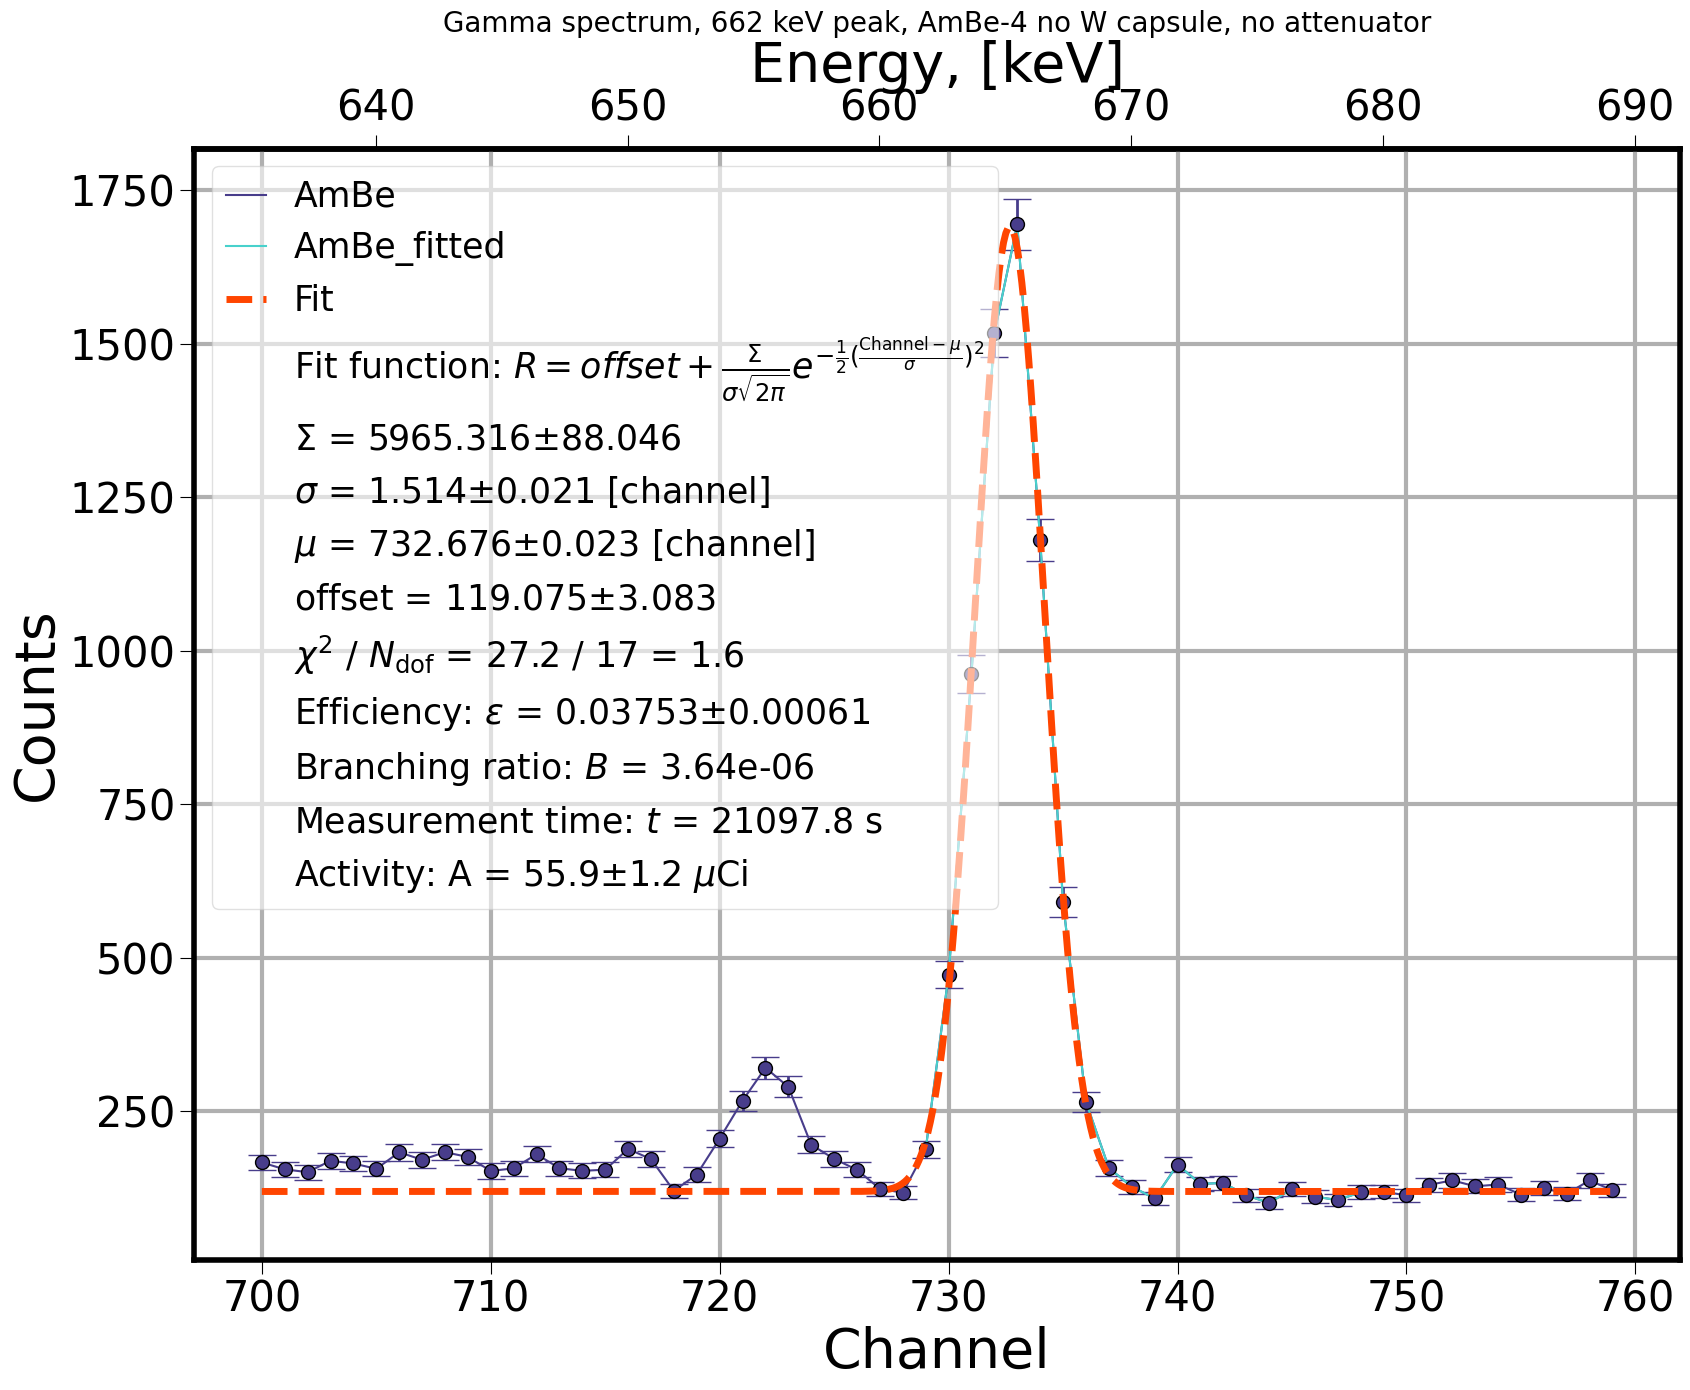

In [7]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares


# Define function and its inverse to make the secons x axis with channels converted to enery
f = lambda x: (x-p0)/p1
g = lambda x: p1*x+p0

plt.figure()
fig, ax1 = plt.subplots()

plt.title('Gamma spectrum, 662 keV peak, AmBe-4 no W capsule, no attenuator', fontsize=20)

ax2 = ax1.secondary_xaxis("top", functions=(f,g))



#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax2.set_xlabel( "Energy, [keV]", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    
for tl in ax2.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)

for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)
ax2.tick_params(length=10)

fig.tight_layout()









channels=np.asarray(scan[0][0][700:760])
counts_no_bkg=np.asarray(scan[0][1])[700:760]-np.asarray(bkg[700:760])/t_bkg*t
counts_no_bkg_err=np.sqrt(np.asarray(scan[0][1])[700:760]-np.asarray(bkg[700:760])/t_bkg*t)

channels_to_fit=np.asarray(scan[0][0][729:750])
counts_no_bkg_to_fit=np.asarray(scan[0][1])[729:750]-np.asarray(bkg[729:750])/t_bkg*t
counts_no_bkg_err_to_fit=np.sqrt(np.asarray(scan[0][1])[729:750]-np.asarray(bkg[729:750])/t_bkg*t)



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, counts_no_bkg, 
                          color="darkslateblue", label="AmBe",  **error_kwargs)

data_err = plt.errorbar(channels, counts_no_bkg, yerr=np.array(counts_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, counts_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, counts_no_bkg_to_fit, counts_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 10000
mu00 = 733
sig00 = 1.5 
offset00 = 0

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
#minuit.fixed["offset"] = True
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
k=chmin
k_end=chmax

while k<=k_end:
    ch.append(k)
    fit.append(normal_distribution(k, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    k+=0.1

Data_fit, = ax1.plot(channels_to_fit, counts_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(counts_no_bkg) - minuit.nfit} = {minuit.fval / (len(counts_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 25}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(counts_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(counts_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)




import scipy.integrate as integrate

B=3.64e-6
efficiency=0.03753 #corrected for sigma
efficiency_err=0.00061 #corrected for sigm


area = integrate.quad(lambda x: normal_distribution(x, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']), 100, 250)




handlelist.append(extra)
labellist.append("Efficiency: $\epsilon$ = {}$\pm${}".format(round(Decimal(efficiency),5), 
                                        round(Decimal(efficiency_err),5)))

handlelist.append(extra)
labellist.append("Branching ratio: $B$ = {}".format(B))
                 
handlelist.append(extra)
labellist.append("Measurement time: $t$ = {} s".format(t))



activity=minuit.values['A']/efficiency/B/t/3.7e10*1e6
activity_err=np.sqrt((minuit.errors['A']/efficiency/t/B/3.7e10*1e6)**2+(minuit.values['A']*efficiency_err/efficiency**2/t/B/3.7e10*1e6)**2)
handlelist.append(extra)
labellist.append("Activity: A = {}$\pm${} $\mu$Ci".format(round(Decimal(activity),1), 
                                        round(Decimal(activity_err),1)))


time_check=minuit.values['A']/efficiency/B/activity/3.7e10*1e6
print(time_check)

fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 25}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"Gamma_spectrum_vs_bkg_AmBe-4_noW_noAt_ADC-Ch_fit_662keV-photopeak_counts.png", bbox_inches ='tight')
plt.show()


activity_mean.append(activity)
activity_err_mean.append(activity_err)
peak_energy.append(662)

<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, 'Gamma spectrum, 722 keV peak, AmBe-4 no W capsule, no attenuator')

Text(0.5, 0, 'Channel')

Text(0.5, 0, 'Energy, [keV]')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 11.21 (χ²/ndof = 0.7)      │              Nfcn = 131              │
│ EDM = 2.25e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  3.07e3   │  0.07e3   │            │            │         │         │       │
│ 1 │ sig    │   1.477   │   0.032   │            │            │         │         │       │
│ 2 │ mu     │  798.501  │   0.034   │            │            │         │         │       │
│ 3 │ offset │   118.1   │    3.2    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │ 4.82e+03   0.7495   0.0078      -87 │
│    sig │   0.7495  0.00103   0.0000  -0.0375 │
│     mu │   0.0078   0.0000  0.00116  -0.0004 │
│ offset │      -87  -0.0375  -0.0004     10.3 │
└────────┴─────────────────────────────────────┘

<ValueView A=3073.7239643582298 sig=1.4767008924065093 mu=798.5008624381028 offset=118.05699559241171>
<ErrorView A=69.39270779530796 sig=0.032032226479446604 mu=0.03411661574697773 offset=3.2024781848034594>
(3073.7239643582298, 1.4767008924065093, 798.5008624381028, 118.05699559241171)
21097.8


/tmp/ipykernel_84486/3050048083.py:282: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


<Figure size 1700x1400 with 0 Axes>

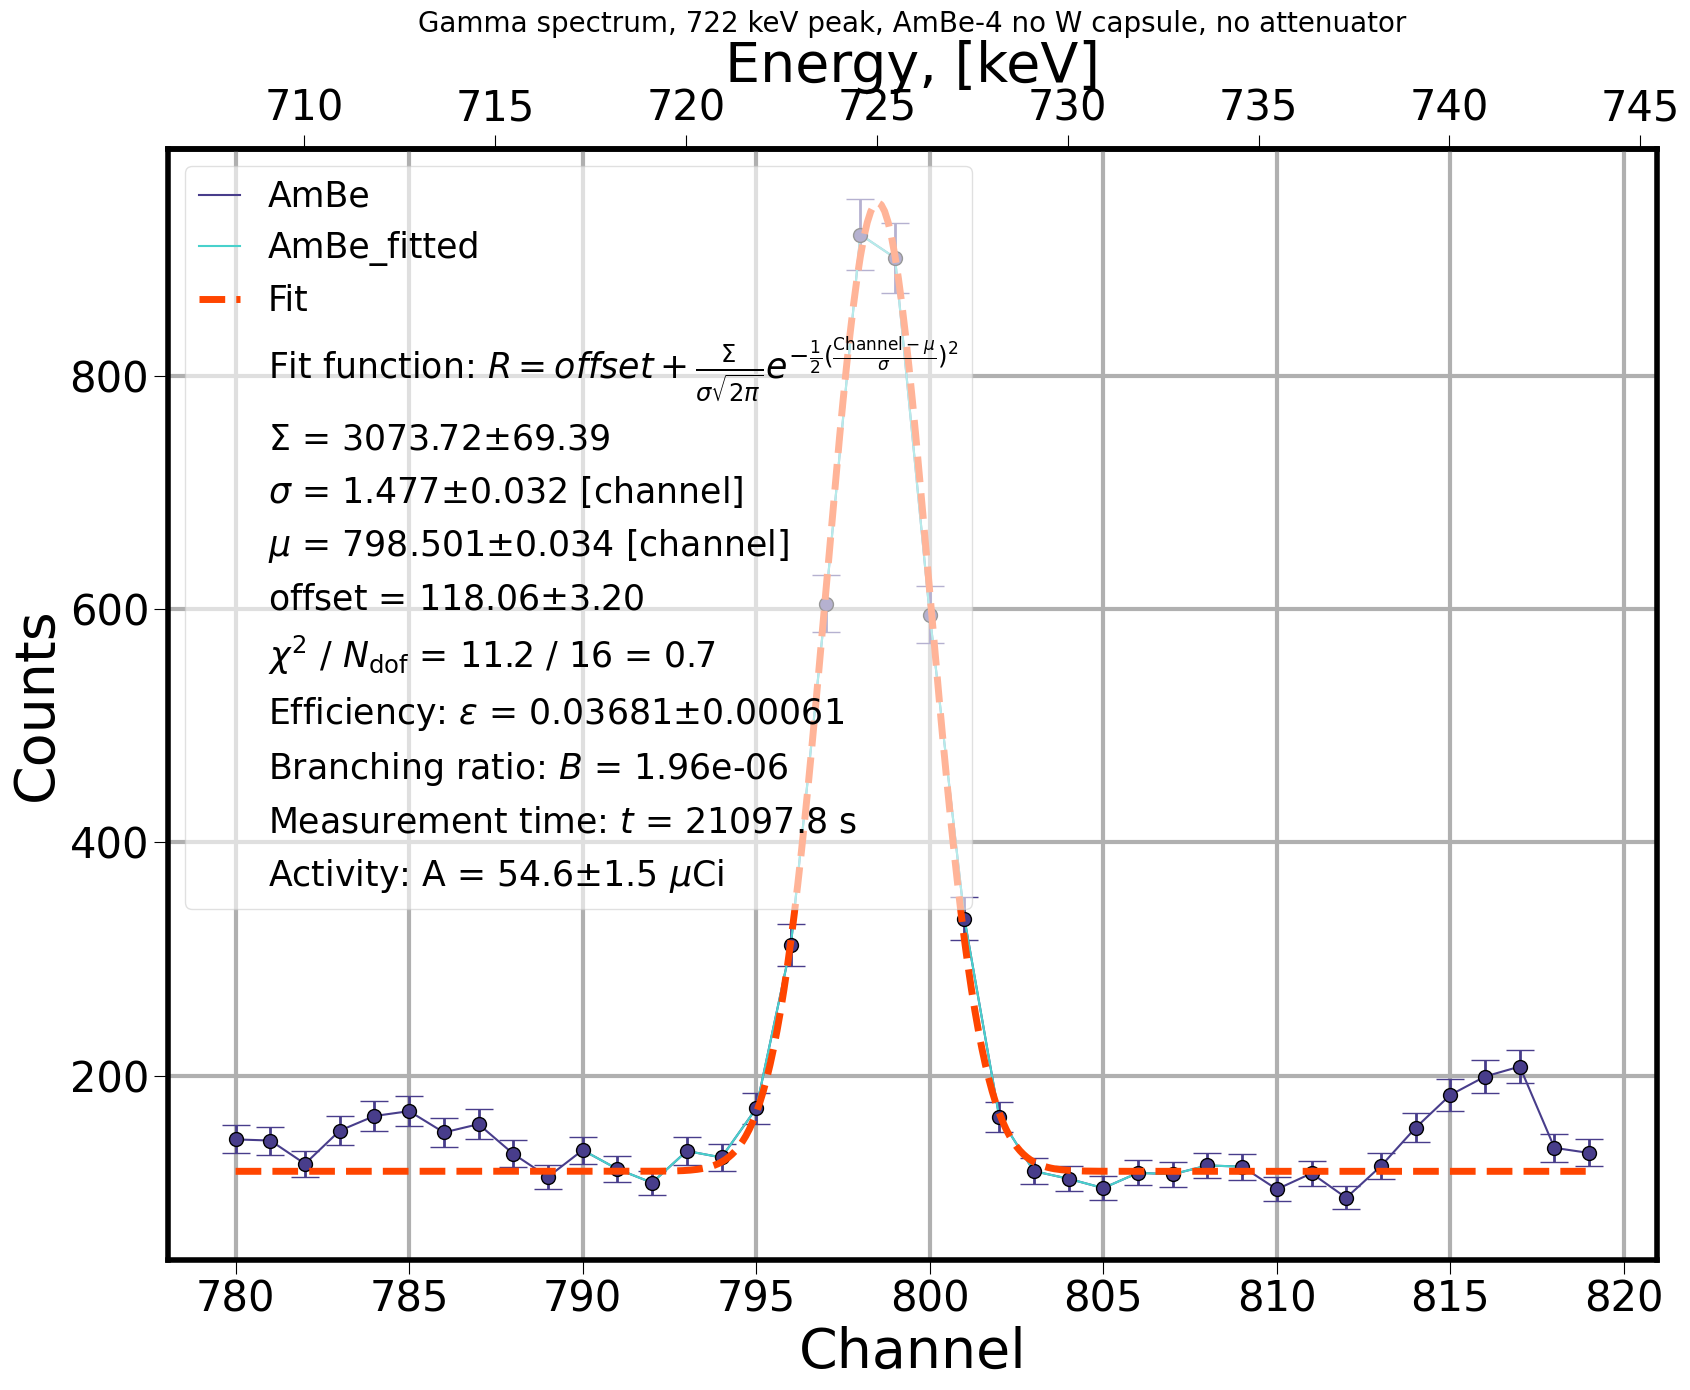

In [8]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

# Define function and its inverse to make the secons x axis with channels converted to enery
f = lambda x: (x-p0)/p1
g = lambda x: p1*x+p0

plt.figure()
fig, ax1 = plt.subplots()

plt.title('Gamma spectrum, 722 keV peak, AmBe-4 no W capsule, no attenuator', fontsize=20)

ax2 = ax1.secondary_xaxis("top", functions=(f,g))



#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax2.set_xlabel( "Energy, [keV]", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    
for tl in ax2.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)

for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)
ax2.tick_params(length=10)

fig.tight_layout()









channels=np.asarray(scan[0][0][780:820])
counts_no_bkg=np.asarray(scan[0][1])[780:820]-np.asarray(bkg[780:820])/t_bkg*t
counts_no_bkg_err=np.sqrt(np.asarray(scan[0][1])[780:820]-np.asarray(bkg[780:820])/t_bkg*t)

channels_to_fit=np.asarray(scan[0][0][790:810])
counts_no_bkg_to_fit=np.asarray(scan[0][1])[790:810]-np.asarray(bkg[790:810])/t_bkg*t
counts_no_bkg_err_to_fit=np.sqrt(np.asarray(scan[0][1])[790:810]-np.asarray(bkg[790:810])/t_bkg*t)



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, counts_no_bkg, 
                          color="darkslateblue", label="AmBe",  **error_kwargs)

data_err = plt.errorbar(channels, counts_no_bkg, yerr=np.array(counts_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, counts_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, counts_no_bkg_to_fit, counts_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 3000
mu00 = 800
sig00 = 5 
offset00 = 160

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
#minuit.fixed["offset"] = True
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
k=chmin
k_end=chmax

while k<=k_end:
    ch.append(k)
    fit.append(normal_distribution(k, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    k+=0.1

Data_fit, = ax1.plot(channels_to_fit, counts_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(counts_no_bkg) - minuit.nfit} = {minuit.fval / (len(counts_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 25}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(counts_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(counts_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)




import scipy.integrate as integrate

B=1.96e-6
efficiency=0.03681 #corrected for sigma
efficiency_err=0.00061 #corrected for sigma


area = integrate.quad(lambda x: normal_distribution(x, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']), 100, 250)




handlelist.append(extra)
labellist.append("Efficiency: $\epsilon$ = {}$\pm${}".format(round(Decimal(efficiency),5), 
                                        round(Decimal(efficiency_err),5)))

handlelist.append(extra)
labellist.append("Branching ratio: $B$ = {}".format(B))
                 
handlelist.append(extra)
labellist.append("Measurement time: $t$ = {} s".format(t))


activity=minuit.values['A']/efficiency/B/t/3.7e10*1e6
activity_err=np.sqrt((minuit.errors['A']/efficiency/t/B/3.7e10*1e6)**2+(minuit.values['A']*efficiency_err/efficiency**2/t/B/3.7e10*1e6)**2)
handlelist.append(extra)
labellist.append("Activity: A = {}$\pm${} $\mu$Ci".format(round(Decimal(activity),1), 
                                        round(Decimal(activity_err),1)))


time_check=minuit.values['A']/efficiency/B/activity/3.7e10*1e6
print(time_check)

fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 25}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"Gamma_spectrum_vs_bkg_AmBe-4_noW_noAt_ADC-Ch_fit_722keV-photopeak_counts.png", bbox_inches ='tight')
plt.show()

activity_mean.append(activity)
activity_err_mean.append(activity_err)
peak_energy.append(722)

<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, 'Gamma spectrum, 653 keV peak, AmBe-4 no W capsule, no attenuator')

Text(0.5, 0, 'Channel')

Text(0.5, 0, 'Energy, [keV]')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.817 (χ²/ndof = 1.4)      │              Nfcn = 141              │
│ EDM = 3.06e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    740    │    80     │            │            │         │         │       │
│ 1 │ sig    │   1.59    │   0.18    │            │            │         │         │       │
│ 2 │ mu     │  722.07   │   0.11    │            │            │         │         │       │
│ 3 │ offset │    126    │     8     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │ 7.16e+03   11.744    0.220     -570 │
│    sig │   11.744   0.0318   -0.001   -0.949 │
│     mu │    0.220   -0.001    0.013   -0.100 │
│ offset │     -570   -0.949   -0.100     66.2 │
└────────┴─────────────────────────────────────┘

<ValueView A=735.6582737956627 sig=1.5899704455722756 mu=722.0745202775107 offset=126.46718604515192>
<ErrorView A=84.63692998904463 sig=0.17837072283813393 mu=0.11383026939063516 offset=8.135877960272406>
(735.6582737956627, 1.5899704455722756, 722.0745202775107, 126.46718604515192)
21097.8


/tmp/ipykernel_84486/548466216.py:286: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


<Figure size 1700x1400 with 0 Axes>

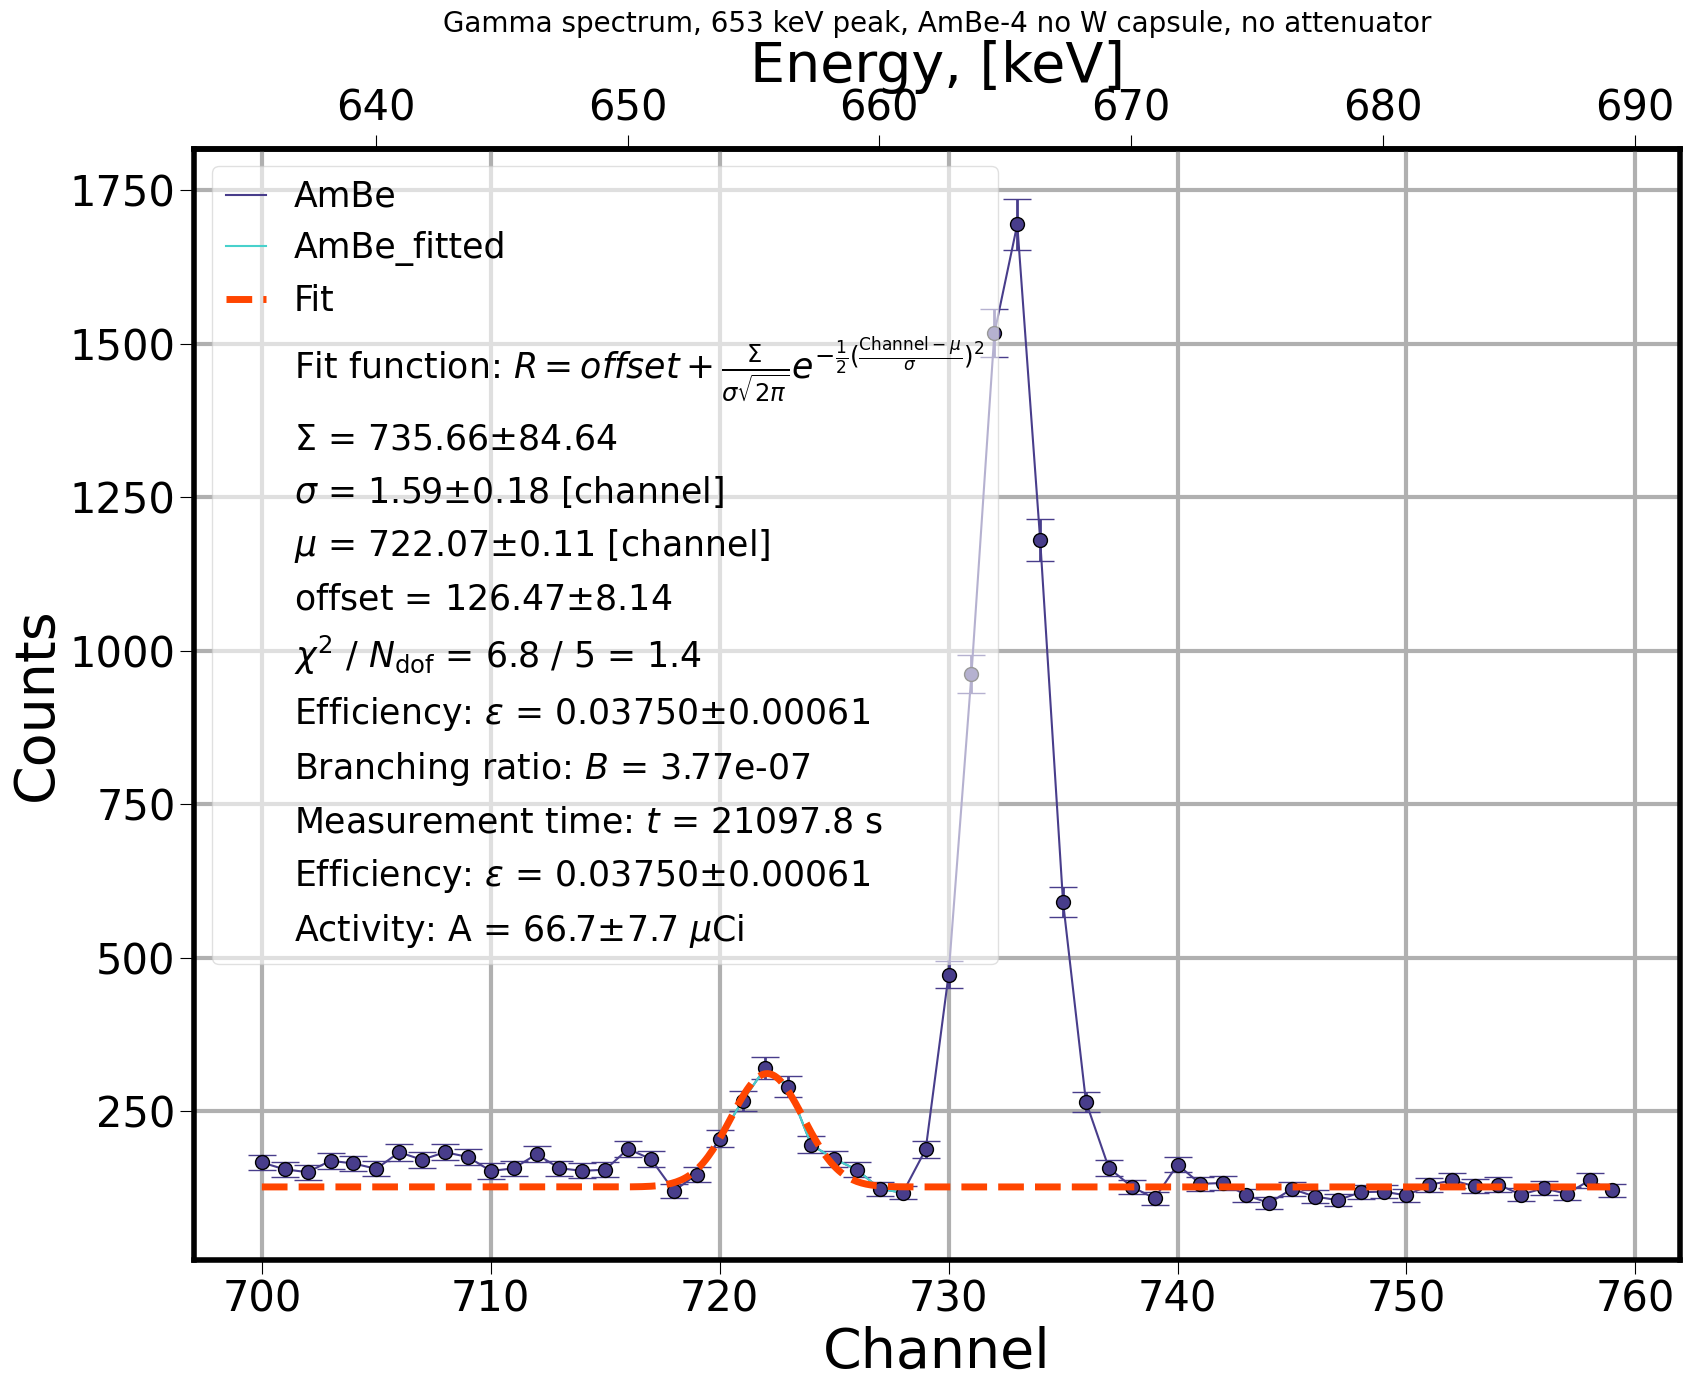

In [9]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares


# Define function and its inverse to make the secons x axis with channels converted to enery
f = lambda x: (x-p0)/p1
g = lambda x: p1*x+p0

plt.figure()
fig, ax1 = plt.subplots()

plt.title('Gamma spectrum, 653 keV peak, AmBe-4 no W capsule, no attenuator', fontsize=20)

ax2 = ax1.secondary_xaxis("top", functions=(f,g))



#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax2.set_xlabel( "Energy, [keV]", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    
for tl in ax2.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)

for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)
ax2.tick_params(length=10)

fig.tight_layout()









channels=np.asarray(scan[0][0][700:760])
counts_no_bkg=np.asarray(scan[0][1])[700:760]-np.asarray(bkg[700:760])/t_bkg*t
counts_no_bkg_err=np.sqrt(np.asarray(scan[0][1])[700:760]-np.asarray(bkg[700:760])/t_bkg*t)

channels_to_fit=np.asarray(scan[0][0][720:729])
counts_no_bkg_to_fit=np.asarray(scan[0][1])[720:729]-np.asarray(bkg[720:729])/t_bkg*t
counts_no_bkg_err_to_fit=np.sqrt(np.asarray(scan[0][1])[720:729]-np.asarray(bkg[720:729])/t_bkg*t)



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, counts_no_bkg, 
                          color="darkslateblue", label="AmBe",  **error_kwargs)

data_err = plt.errorbar(channels, counts_no_bkg, yerr=np.array(counts_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, counts_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, counts_no_bkg_to_fit, counts_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 726
mu00 = 722
sig00 = 1.56 
offset00 = 0

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
#minuit.fixed["offset"] = True
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
k=chmin
k_end=chmax

while k<=k_end:
    ch.append(k)
    fit.append(normal_distribution(k, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    k+=0.1

Data_fit, = ax1.plot(channels_to_fit, counts_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(counts_no_bkg) - minuit.nfit} = {minuit.fval / (len(counts_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 25}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(counts_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(counts_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)




import scipy.integrate as integrate

B=3.77e-7
efficiency=0.03750 #corrected for sigma
efficiency_err=0.00061 #corrected for sigma


area = integrate.quad(lambda x: normal_distribution(x, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']), 100, 250)




handlelist.append(extra)
labellist.append("Efficiency: $\epsilon$ = {}$\pm${}".format(round(Decimal(efficiency),5), 
                                        round(Decimal(efficiency_err),5)))

handlelist.append(extra)
labellist.append("Branching ratio: $B$ = {}".format(B))
                 
handlelist.append(extra)
labellist.append("Measurement time: $t$ = {} s".format(t))

handlelist.append(extra)
labellist.append("Efficiency: $\epsilon$ = {}$\pm${}".format(round(Decimal(efficiency),5), 
                                        round(Decimal(efficiency_err),5)))

activity=minuit.values['A']/efficiency/B/t/3.7e10*1e6
activity_err=np.sqrt((minuit.errors['A']/efficiency/t/B/3.7e10*1e6)**2+(minuit.values['A']*efficiency_err/efficiency**2/t/B/3.7e10*1e6)**2)
handlelist.append(extra)
labellist.append("Activity: A = {}$\pm${} $\mu$Ci".format(round(Decimal(activity),1), 
                                        round(Decimal(activity_err),1)))


time_check=minuit.values['A']/efficiency/B/activity/3.7e10*1e6
print(time_check)

fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 25}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"Gamma_spectrum_vs_bkg_AmBe-4_noW_noAt_ADC-Ch_fit_653keV-photopeak_counts.png", bbox_inches ='tight')
plt.show()

activity_mean.append(activity)
activity_err_mean.append(activity_err)
peak_energy.append(653)

<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, 'Gamma spectrum, 368&376 keV peak, AmBe-4 with W capsule, with attenuator')

Text(0.5, 0, 'Channel')

Text(0.5, 0, 'Energy, [keV]')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.8 (χ²/ndof = 0.0)        │              Nfcn = 177              │
│ EDM = 6.14e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   1.2e3   │   1.4e3   │            │            │         │         │       │
│ 1 │ sig1   │    1.7    │    1.1    │            │            │         │         │       │
│ 2 │ mu1    │   408.4   │    1.3    │            │            │         │         │       │
│ 3 │ A2     │   1.2e3   │   1.4e3   │            │            │         │         │       │
│ 4 │ sig2   │    1.7    │    1.1    │            │            │         │         │       │
│ 5 │ mu2    │   408.4   │    1.3    │            │            │         │         │       │
│ 6 │ offset │    240    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬────────────────────────────────────────────────────────────────┐
│        │       A1     sig1      mu1       A2     sig2      mu2   offset │
├────────┼────────────────────────────────────────────────────────────────┤
│     A1 │ 2.02e+06    112.7     18.9   -0.6e6    112.7     18.9   -6.8e3 │
│   sig1 │    112.7     1.28      0.3    112.7      0.8      0.3     -9.0 │
│    mu1 │     18.9      0.3     1.58     18.9      0.3      1.2     -1.6 │
│     A2 │   -0.6e6    112.7     18.9 2.02e+06    112.7     18.9   -6.8e3 │
│   sig2 │    112.7      0.8      0.3    112.7     1.28      0.3     -9.0 │
│    mu2 │     18.9      0.3      1.2     18.9      0.3     1.58     -1.6 │
│ offset │   -6.8e3     -9.0     -1.6   -6.8e3     -9.0     -1.6 1.48e+03 │
└────────┴────────────────────────────────────────────────────────────────┘

<ValueView A1=1249.8979445345203 sig1=1.657494112240859 mu1=408.41750336799475 A2=1249.8979410155284 sig2=1.6574941128728304 mu2=408.4175033676461 offset=240.2409139211338>
<ErrorView A1=1422.1480837020015 sig1=1.1304766525969119 mu1=1.2560846764700366 A2=1422.1480816845067 sig2=1.1304766550553433 mu2=1.2560846769981044 offset=38.51858061790018>
(1249.8979445345203, 1.657494112240859, 408.41750336799475, 1249.8979410155284, 1.6574941128728304, 408.4175033676461, 240.2409139211338)


/tmp/ipykernel_84486/3576221528.py:290: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


<Figure size 1700x1400 with 0 Axes>

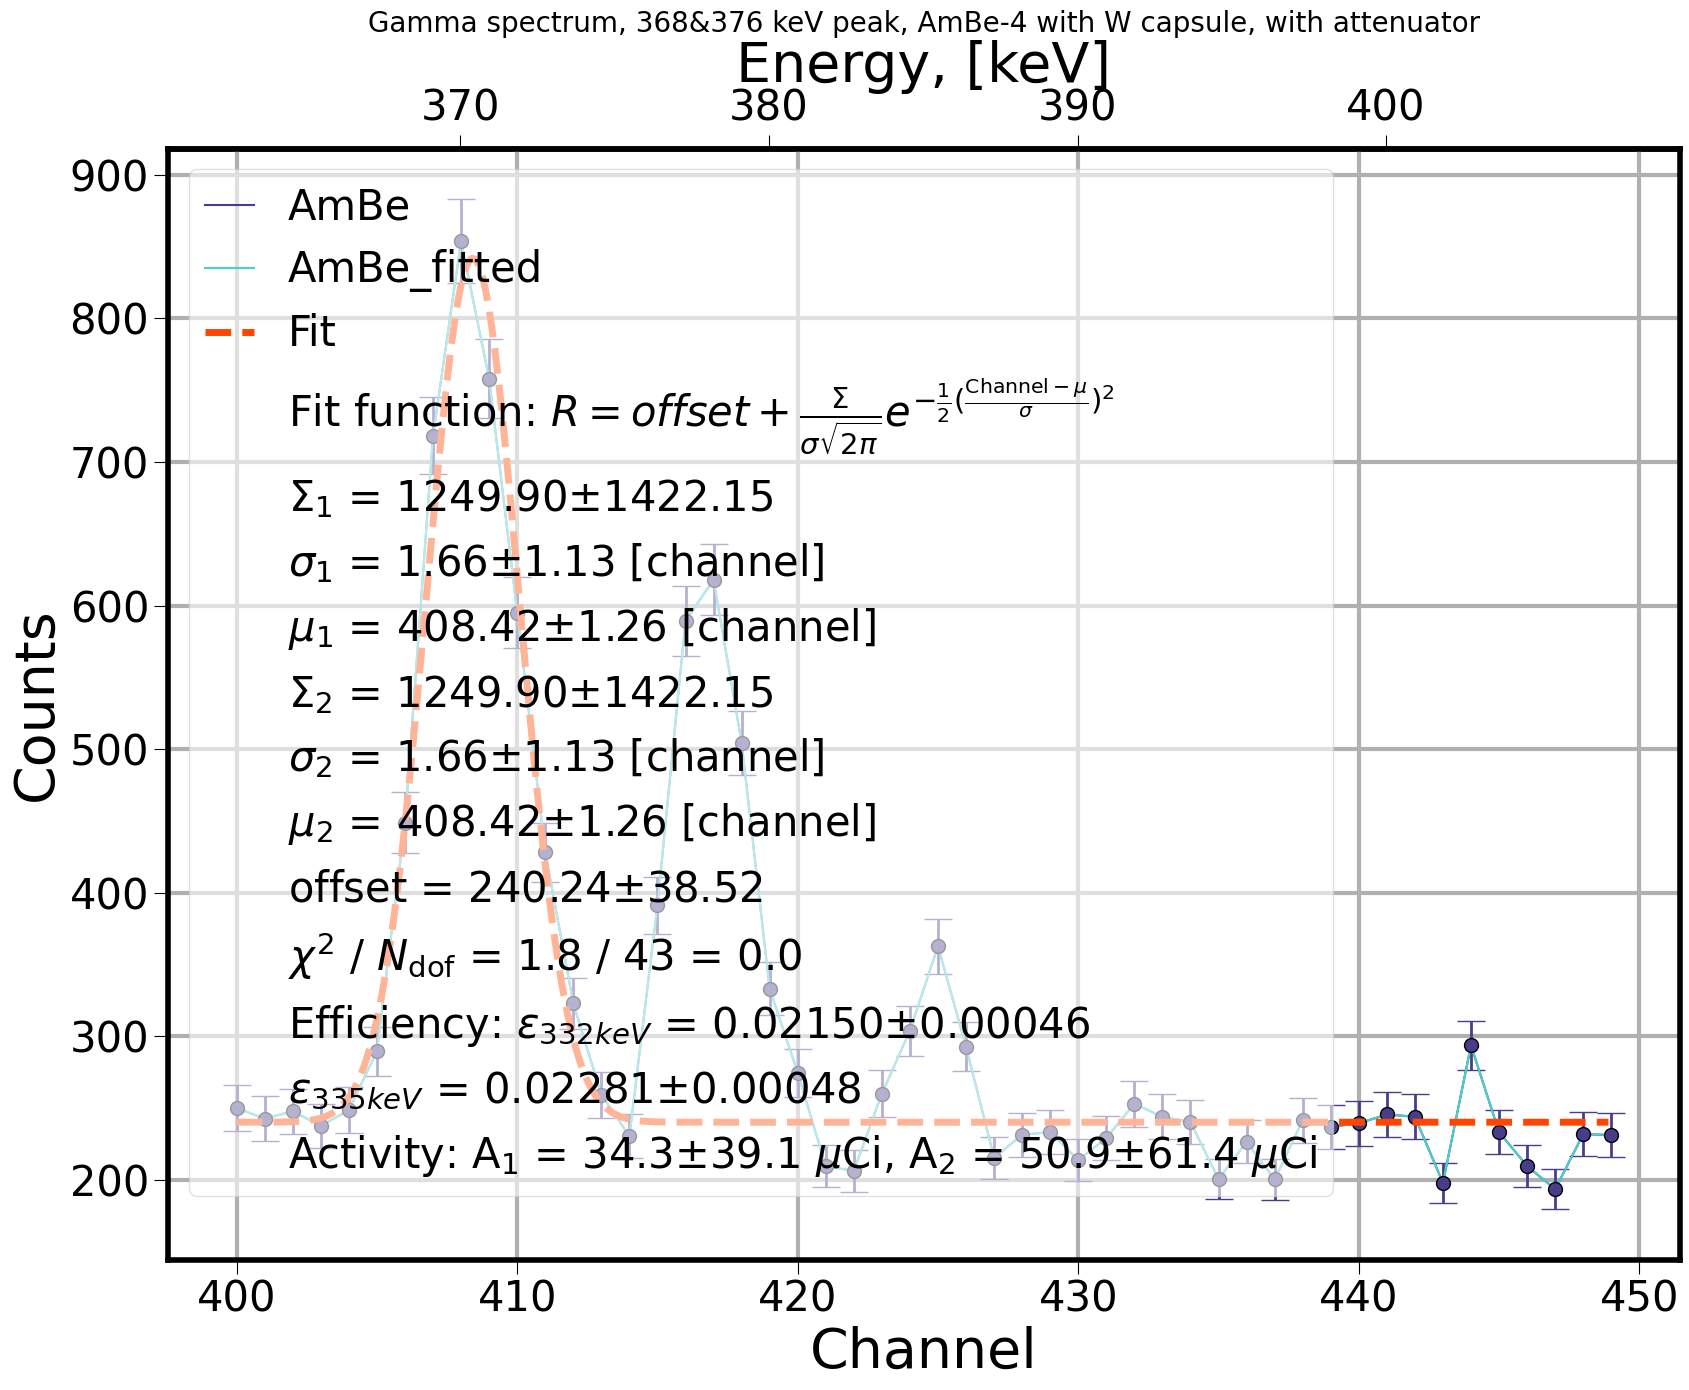

In [10]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


# Define function and its inverse to make the secons x axis with channels converted to enery
f = lambda x: (x-p0)/p1
g = lambda x: p1*x+p0

#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('Gamma spectrum, 368&376 keV peak, AmBe-4 with W capsule, with attenuator', fontsize=20)



ax2 = ax1.secondary_xaxis("top", functions=(f,g))



#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax2.set_xlabel( "Energy, [keV]", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    
for tl in ax2.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)

for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)
ax2.tick_params(length=10)

fig.tight_layout()









channels=np.asarray(scan[0][0][400:450])
counts_no_bkg=np.asarray(scan[0][1])[400:450]-np.asarray(bkg[400:450])/t_bkg*t
counts_no_bkg_err=np.sqrt(np.asarray(scan[0][1])[400:450]-np.asarray(bkg[400:450])/t_bkg*t)

channels_to_fit=np.asarray(scan[0][0][400:450])
counts_no_bkg_to_fit=np.asarray(scan[0][1])[400:450]-np.asarray(bkg[400:450])/t_bkg*t
counts_no_bkg_err_to_fit=np.sqrt(np.asarray(scan[0][1])[400:450]-np.asarray(bkg[400:450])/t_bkg*t)




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, counts_no_bkg, 
                          color="darkslateblue", label="AmBe",  **error_kwargs)

data_err = plt.errorbar(channels, counts_no_bkg, yerr=np.array(counts_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, counts_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A1, sig1, mu1, A2, sig2, mu2, offset):
    return offset+A1/np.sqrt(2*math.pi)/sig1 * np.exp(-1/2*((x-mu1)/sig1)**2)+A2/np.sqrt(2*math.pi)/sig2 * np.exp(-1/2*((x-mu2)/sig2)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, counts_no_bkg_to_fit, counts_no_bkg_to_fit, normal_distribution)





#set initial parameter values
A100 = 3000
mu100 = 408
sig100 = 1.5 
A200 = 5000
mu200 = 417
sig200 = 1.5 
offset00 = 580

#assemble list fit arguments for the minimizer
namelist = ['A1', 'sig1', 'mu1','A2', 'sig2', 'mu2','offset']
kwargs = dict(A1=A100, sig1=sig100, mu1=mu100, A2=A100, sig2=sig100, mu2=mu100, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
k=chmin
k_end=chmax

while k<=k_end:
    ch.append(k)
    fit.append(normal_distribution(k, minuit.values['A1'], minuit.values['sig1'], minuit.values['mu1'], minuit.values['A2'], minuit.values['sig2'], minuit.values['mu2'], minuit.values['offset']))
    k+=0.1

Data_fit, = ax1.plot(channels_to_fit, counts_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(counts_no_bkg) - minuit.nfit} = {minuit.fval / (len(counts_no_bkg) - minuit.nfit) :.1f}"













extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma_1$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A1']),number_sigdigs(minuit.errors['A1'])), 
                                        round(Decimal(minuit.errors['A1']),number_sigdigs(minuit.errors['A1']))),
      r'$\sigma_1$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig1']),number_sigdigs(minuit.errors['sig1'])), 
                                        round(Decimal(minuit.errors['sig1']),number_sigdigs(minuit.errors['sig1']))),
      r'$\mu_1$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu1']),number_sigdigs(minuit.errors['mu1'])), 
                                        round(Decimal(minuit.errors['mu1']),number_sigdigs(minuit.errors['mu1']))),
      r'$\Sigma_2$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A2']),number_sigdigs(minuit.errors['A2'])), 
                                        round(Decimal(minuit.errors['A2']),number_sigdigs(minuit.errors['A2']))),
      r'$\sigma_2$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig2']),number_sigdigs(minuit.errors['sig2'])), 
                                        round(Decimal(minuit.errors['sig2']),number_sigdigs(minuit.errors['sig2']))),
      r'$\mu_2$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu2']),number_sigdigs(minuit.errors['mu2'])), 
                                        round(Decimal(minuit.errors['mu2']),number_sigdigs(minuit.errors['mu2']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(counts_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(counts_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)




import scipy.integrate as integrate


B1=2.17E-06
efficiency1=0.0215
efficiency_err1=0.000463680924775

B2=1.38E-06
efficiency2=0.02281
efficiency_err2=0.00047759815745





handlelist.append(extra)
labellist.append("Efficiency: $\epsilon_{332keV}$"+" = {}$\pm${}".format(round(Decimal(efficiency1),5), 
                                        round(Decimal(efficiency_err1),5)))

handlelist.append(extra)
labellist.append("$\epsilon_{335keV}$"+" = {}$\pm${}".format(round(Decimal(efficiency2),5), 
                                        round(Decimal(efficiency_err2),5)))

activity1=minuit.values['A1']/efficiency1/t/B1/3.7e10*1e6
activity_err1=np.sqrt((minuit.errors['A1']/efficiency1/t/B1/3.7e10*1e6)**2+(minuit.values['A1']*efficiency_err1/efficiency1**2/t/B1/3.7e10*1e6)**2)
activity2=minuit.values['A2']/efficiency2/t/B2/3.7e10*1e6
activity_err2=np.sqrt((minuit.errors['A2']/efficiency1/t/B2/3.7e10*1e6)**2+(minuit.values['A2']*efficiency_err2/efficiency2**2/t/B2/3.7e10*1e6)**2)

handlelist.append(extra)
labellist.append("Activity: A$_1$ = {}$\pm${} $\mu$Ci, ".format(round(Decimal(activity1),1), 
                                        round(Decimal(activity_err1),1)) + "A$_2$ = {}$\pm${} $\mu$Ci".format(round(Decimal(activity2),1), 
                                        round(Decimal(activity_err2),1)))


fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"Gamma_spectrum_vs_bkg_AmBe-4_withW_withAt_ADC-Ch_fit_368-376keV-photopeak_counts.png", bbox_inches ='tight')
plt.show()


#activity_mean.append(activity1)
#activity_err_mean.append(activity_err1)


#activity_mean.append(activity2)
#activity_err_mean.append(activity_err2)


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, 'Gamma spectrum, 368 keV peak, AmBe-4 no W capsule, no attenuator')

Text(0.5, 0, 'Channel')

Text(0.5, 0, 'Energy, [keV]')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 10.68 (χ²/ndof = 1.3)      │              Nfcn = 114              │
│ EDM = 0.000124 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  2.48e3   │  0.09e3   │            │            │         │         │       │
│ 1 │ sig    │   1.62    │   0.06    │            │            │         │         │       │
│ 2 │ mu     │  408.33   │   0.05    │            │            │         │         │       │
│ 3 │ offset │    240    │     7     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │ 8.57e+03   2.9585   0.3241     -450 │
│    sig │   2.9585  0.00315   0.0006  -0.1909 │
│     mu │   0.3241   0.0006  0.00287   0.0027 │
│ offset │     -450  -0.1909   0.0027     53.5 │
└────────┴─────────────────────────────────────┘

<ValueView A=2484.3221259242623 sig=1.6191077107656713 mu=408.3301854273294 offset=240.1443131832255>
<ErrorView A=92.57101985904431 sig=0.056168436100120206 mu=0.053558286682564404 offset=7.315244213049325>
(2484.3221259242623, 1.6191077107656713, 408.3301854273294, 240.1443131832255)
21097.8


/tmp/ipykernel_84486/1564596700.py:286: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


<Figure size 1700x1400 with 0 Axes>

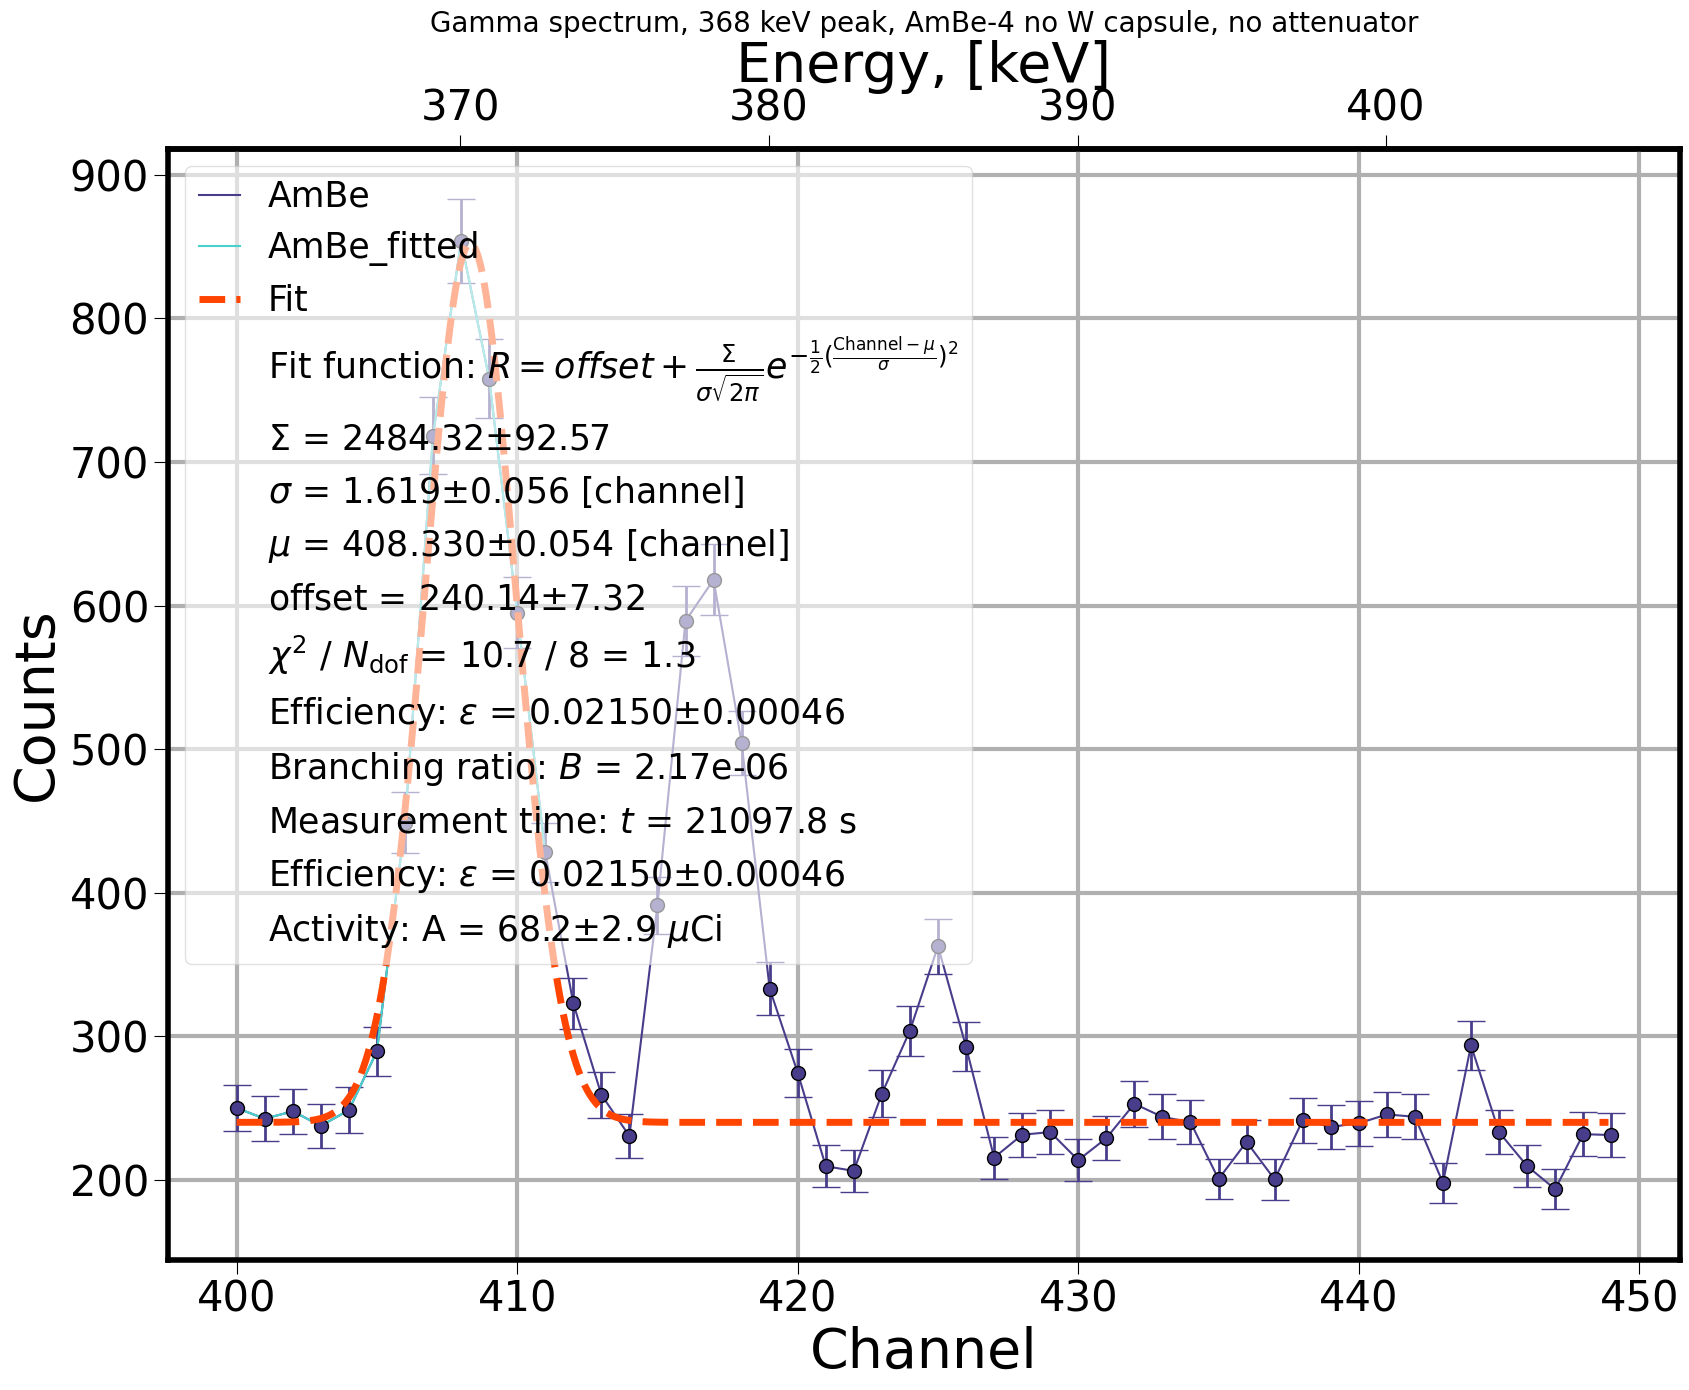

In [11]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares


# Define function and its inverse to make the secons x axis with channels converted to enery
f = lambda x: (x-p0)/p1
g = lambda x: p1*x+p0

plt.figure()
fig, ax1 = plt.subplots()

plt.title('Gamma spectrum, 368 keV peak, AmBe-4 no W capsule, no attenuator', fontsize=20)

ax2 = ax1.secondary_xaxis("top", functions=(f,g))



#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax2.set_xlabel( "Energy, [keV]", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    
for tl in ax2.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)

for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)
ax2.tick_params(length=10)

fig.tight_layout()









channels=np.asarray(scan[0][0][400:450])
counts_no_bkg=np.asarray(scan[0][1])[400:450]-np.asarray(bkg[400:450])/t_bkg*t
counts_no_bkg_err=np.sqrt(np.asarray(scan[0][1])[400:450]-np.asarray(bkg[400:450])/t_bkg*t)

channels_to_fit=np.asarray(scan[0][0][400:412])
counts_no_bkg_to_fit=np.asarray(scan[0][1])[400:412]-np.asarray(bkg[400:412])/t_bkg*t
counts_no_bkg_err_to_fit=np.sqrt(np.asarray(scan[0][1])[400:412]-np.asarray(bkg[400:412])/t_bkg*t)



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, counts_no_bkg, 
                          color="darkslateblue", label="AmBe",  **error_kwargs)

data_err = plt.errorbar(channels, counts_no_bkg, yerr=np.array(counts_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, counts_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, counts_no_bkg_to_fit, counts_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1500
mu00 = 410
sig00 = 1 
offset00 = 160

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
#minuit.fixed["offset"] = True
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
k=chmin
k_end=chmax

while k<=k_end:
    ch.append(k)
    fit.append(normal_distribution(k, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    k+=0.1

Data_fit, = ax1.plot(channels_to_fit, counts_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(counts_no_bkg) - minuit.nfit} = {minuit.fval / (len(counts_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 25}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(counts_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(counts_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)




import scipy.integrate as integrate

B=2.17e-6
efficiency=0.0215
efficiency_err=0.00046


area = integrate.quad(lambda x: normal_distribution(x, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']), 100, 250)




handlelist.append(extra)
labellist.append("Efficiency: $\epsilon$ = {}$\pm${}".format(round(Decimal(efficiency),5), 
                                        round(Decimal(efficiency_err),5)))

handlelist.append(extra)
labellist.append("Branching ratio: $B$ = {}".format(B))
                 
handlelist.append(extra)
labellist.append("Measurement time: $t$ = {} s".format(t))

handlelist.append(extra)
labellist.append("Efficiency: $\epsilon$ = {}$\pm${}".format(round(Decimal(efficiency),5), 
                                        round(Decimal(efficiency_err),5)))

activity=minuit.values['A']/efficiency/B/t/3.7e10*1e6
activity_err=np.sqrt((minuit.errors['A']/efficiency/t/B/3.7e10*1e6)**2+(minuit.values['A']*efficiency_err/efficiency**2/t/B/3.7e10*1e6)**2)
handlelist.append(extra)
labellist.append("Activity: A = {}$\pm${} $\mu$Ci".format(round(Decimal(activity),1), 
                                        round(Decimal(activity_err),1)))


time_check=minuit.values['A']/efficiency/B/activity/3.7e10*1e6
print(time_check)

fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 25}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"Gamma_spectrum_vs_bkg_AmBe-4_noW_noAt_ADC-Ch_fit_368keV-photopeak_counts.png", bbox_inches ='tight')
plt.show()

#activity_mean.append(activity)
#activity_err_mean.append(activity_err)
#peak_energy.append(368)

<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, 'Gamma spectrum, 376 keV peak, AmBe-4 no W capsule, no attenuator')

Text(0.5, 0, 'Channel')

Text(0.5, 0, 'Energy, [keV]')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 143.6 (χ²/ndof = 4.4)      │              Nfcn = 93               │
│ EDM = 0.000128 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  1.31e3   │  0.06e3   │            │            │         │         │       │
│ 1 │ sig    │   1.27    │   0.06    │            │            │         │         │       │
│ 2 │ mu     │  416.83   │   0.06    │            │            │         │         │       │
│ 3 │ offset │   234.5   │    2.8    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │ 3.27e+03   1.3496    0.158      -53 │
│    sig │   1.3496  0.00306   0.0004  -0.0362 │
│     mu │    0.158   0.0004   0.0038   -0.004 │
│ offset │      -53  -0.0362   -0.004     7.77 │
└────────┴─────────────────────────────────────┘

<ValueView A=1305.945225488265 sig=1.2679813478717958 mu=416.82929291355237 offset=234.46372418926768>
<ErrorView A=57.201753464741664 sig=0.05536015734692355 mu=0.06162727635983137 offset=2.7868385320638684>
(1305.945225488265, 1.2679813478717958, 416.82929291355237, 234.46372418926768)
21097.8


/tmp/ipykernel_84486/1608523229.py:283: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


<Figure size 1700x1400 with 0 Axes>

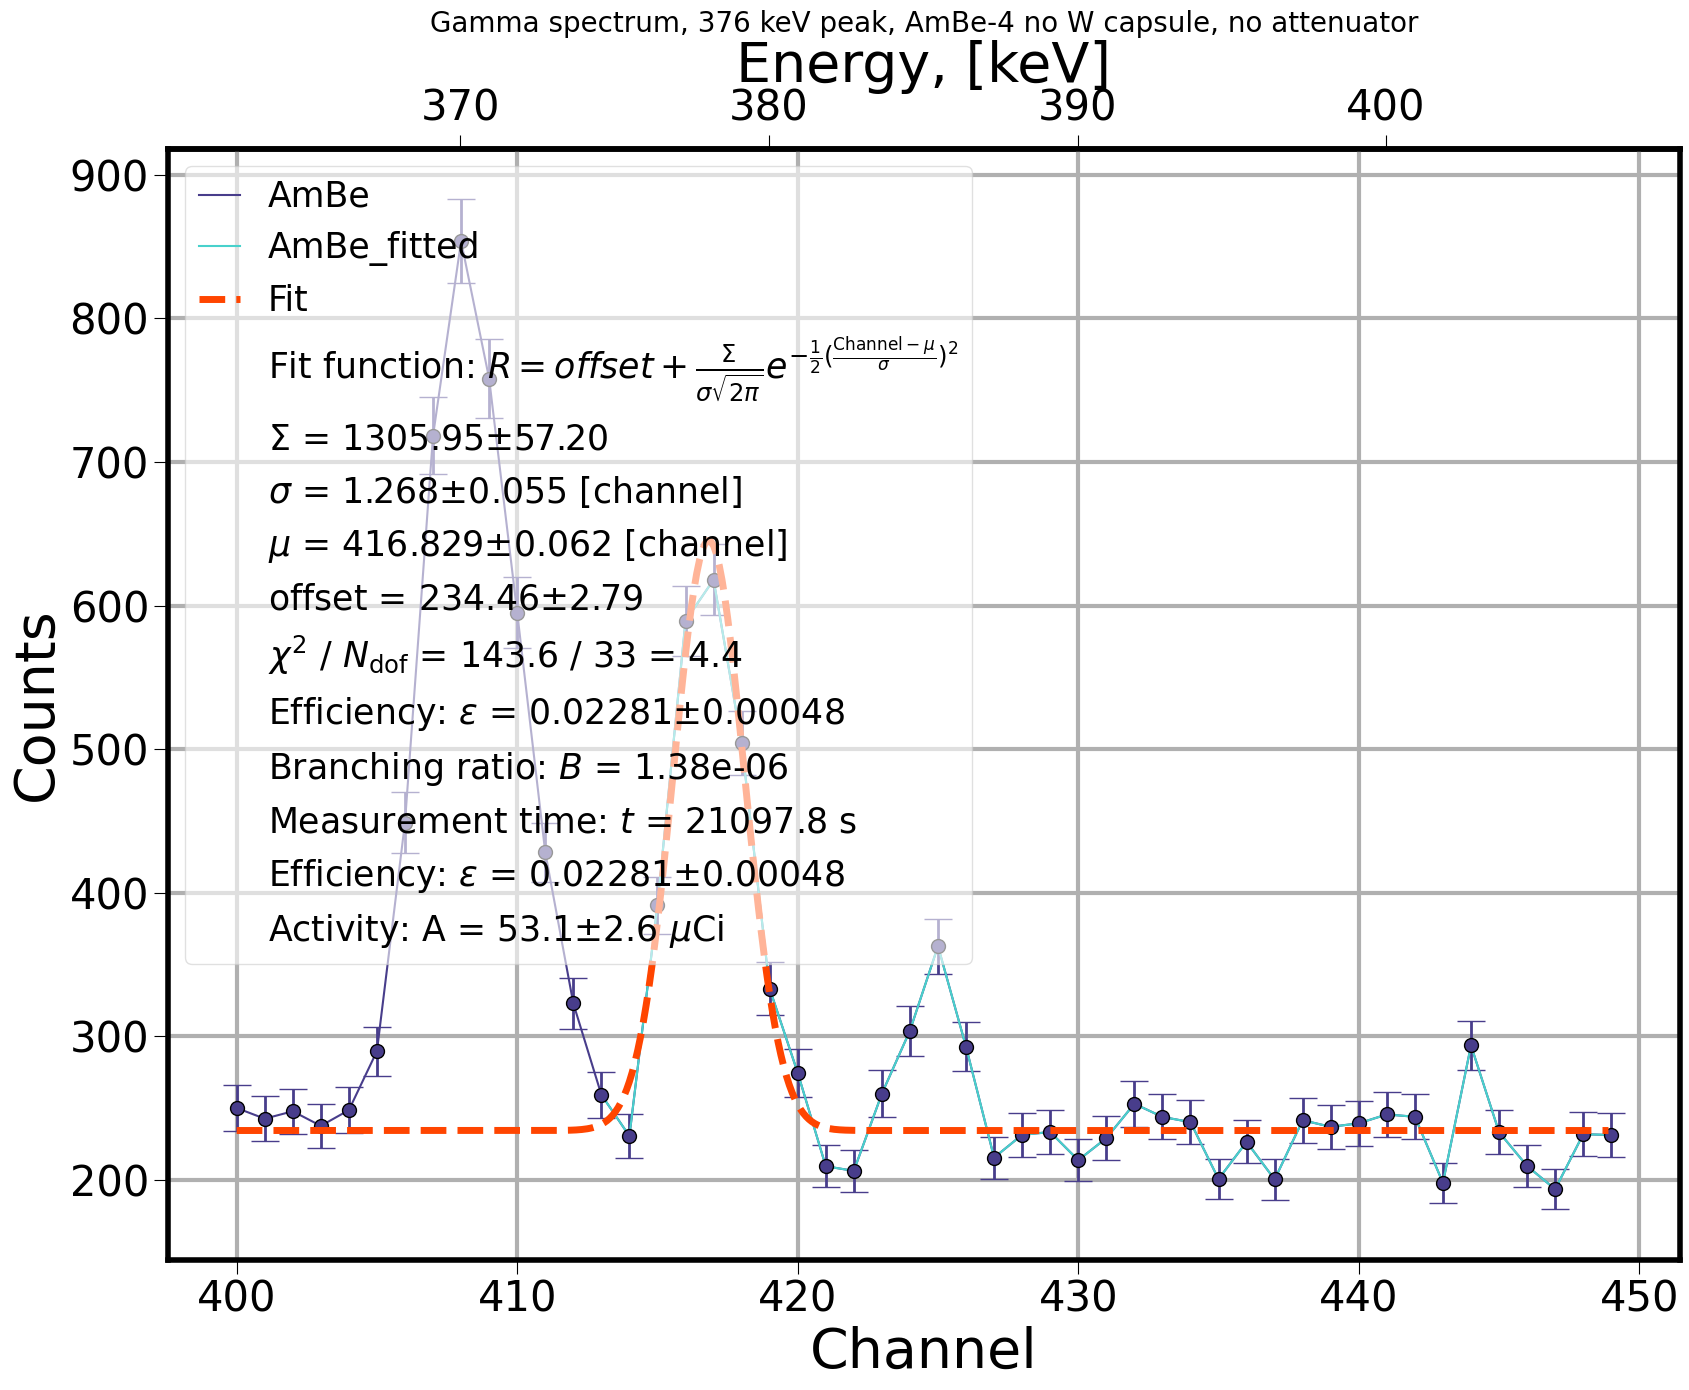

In [12]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('Gamma spectrum, 376 keV peak, AmBe-4 no W capsule, no attenuator', fontsize=20)

ax2 = ax1.secondary_xaxis("top", functions=(f,g))



#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax2.set_xlabel( "Energy, [keV]", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    
for tl in ax2.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)

for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)
ax2.tick_params(length=10)

fig.tight_layout()









channels=np.asarray(scan[0][0][400:450])
counts_no_bkg=np.asarray(scan[0][1])[400:450]-np.asarray(bkg[400:450])/t_bkg*t
counts_no_bkg_err=np.sqrt(np.asarray(scan[0][1])[400:450]-np.asarray(bkg[400:450])/t_bkg*t)

channels_to_fit=np.asarray(scan[0][0][413:450])
counts_no_bkg_to_fit=np.asarray(scan[0][1])[413:450]-np.asarray(bkg[413:450])/t_bkg*t
counts_no_bkg_err_to_fit=np.sqrt(np.asarray(scan[0][1])[413:450]-np.asarray(bkg[413:450])/t_bkg*t)



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, counts_no_bkg, 
                          color="darkslateblue", label="AmBe",  **error_kwargs)

data_err = plt.errorbar(channels, counts_no_bkg, yerr=np.array(counts_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, counts_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, counts_no_bkg_to_fit, counts_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1500
mu00 = 416
sig00 = 1 
offset00 = 160

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
#minuit.fixed["offset"] = True
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
k=chmin
k_end=chmax

while k<=k_end:
    ch.append(k)
    fit.append(normal_distribution(k, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    k+=0.1

Data_fit, = ax1.plot(channels_to_fit, counts_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(counts_no_bkg) - minuit.nfit} = {minuit.fval / (len(counts_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 25}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(counts_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(counts_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)




import scipy.integrate as integrate

B=1.38e-6
efficiency=0.02281
efficiency_err=0.00048


area = integrate.quad(lambda x: normal_distribution(x, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']), 100, 250)




handlelist.append(extra)
labellist.append("Efficiency: $\epsilon$ = {}$\pm${}".format(round(Decimal(efficiency),5), 
                                        round(Decimal(efficiency_err),5)))

handlelist.append(extra)
labellist.append("Branching ratio: $B$ = {}".format(B))
                 
handlelist.append(extra)
labellist.append("Measurement time: $t$ = {} s".format(t))

handlelist.append(extra)
labellist.append("Efficiency: $\epsilon$ = {}$\pm${}".format(round(Decimal(efficiency),5), 
                                        round(Decimal(efficiency_err),5)))

activity=minuit.values['A']/efficiency/B/t/3.7e10*1e6
activity_err=np.sqrt((minuit.errors['A']/efficiency/t/B/3.7e10*1e6)**2+(minuit.values['A']*efficiency_err/efficiency**2/t/B/3.7e10*1e6)**2)
handlelist.append(extra)
labellist.append("Activity: A = {}$\pm${} $\mu$Ci".format(round(Decimal(activity),1), 
                                        round(Decimal(activity_err),1)))


time_check=minuit.values['A']/efficiency/B/activity/3.7e10*1e6
print(time_check)

fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 25}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"Gamma_spectrum_vs_bkg_AmBe-4_noW_noAt_ADC-Ch_fit_376keV-photopeak_counts.png", bbox_inches ='tight')
plt.show()

#activity_mean.append(activity)
#activity_err_mean.append(activity_err)
#peak_energy.append(376)

<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, 'Activity of AmBe-4 no W capsule, no attenuator')

Text(0, 0.5, 'Activity')

Text(0.5, 0, 'Energy, [keV]')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.563 (χ²/ndof = 1.3)      │              Nfcn = 11               │
│ EDM = 3.06e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 1 │ b    │   55.6    │    1.0    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────┐
│   │     a     b │
├───┼─────────────┤
│ a │     0   0.0 │
│ b │   0.0 0.903 │
└───┴─────────────┘

<ValueView a=0.0 b=55.57371696016126>
<ErrorView a=0.1 b=0.9501395897175342>
(0.0, 55.57371696016126)
653
722


<Figure size 1700x1400 with 0 Axes>

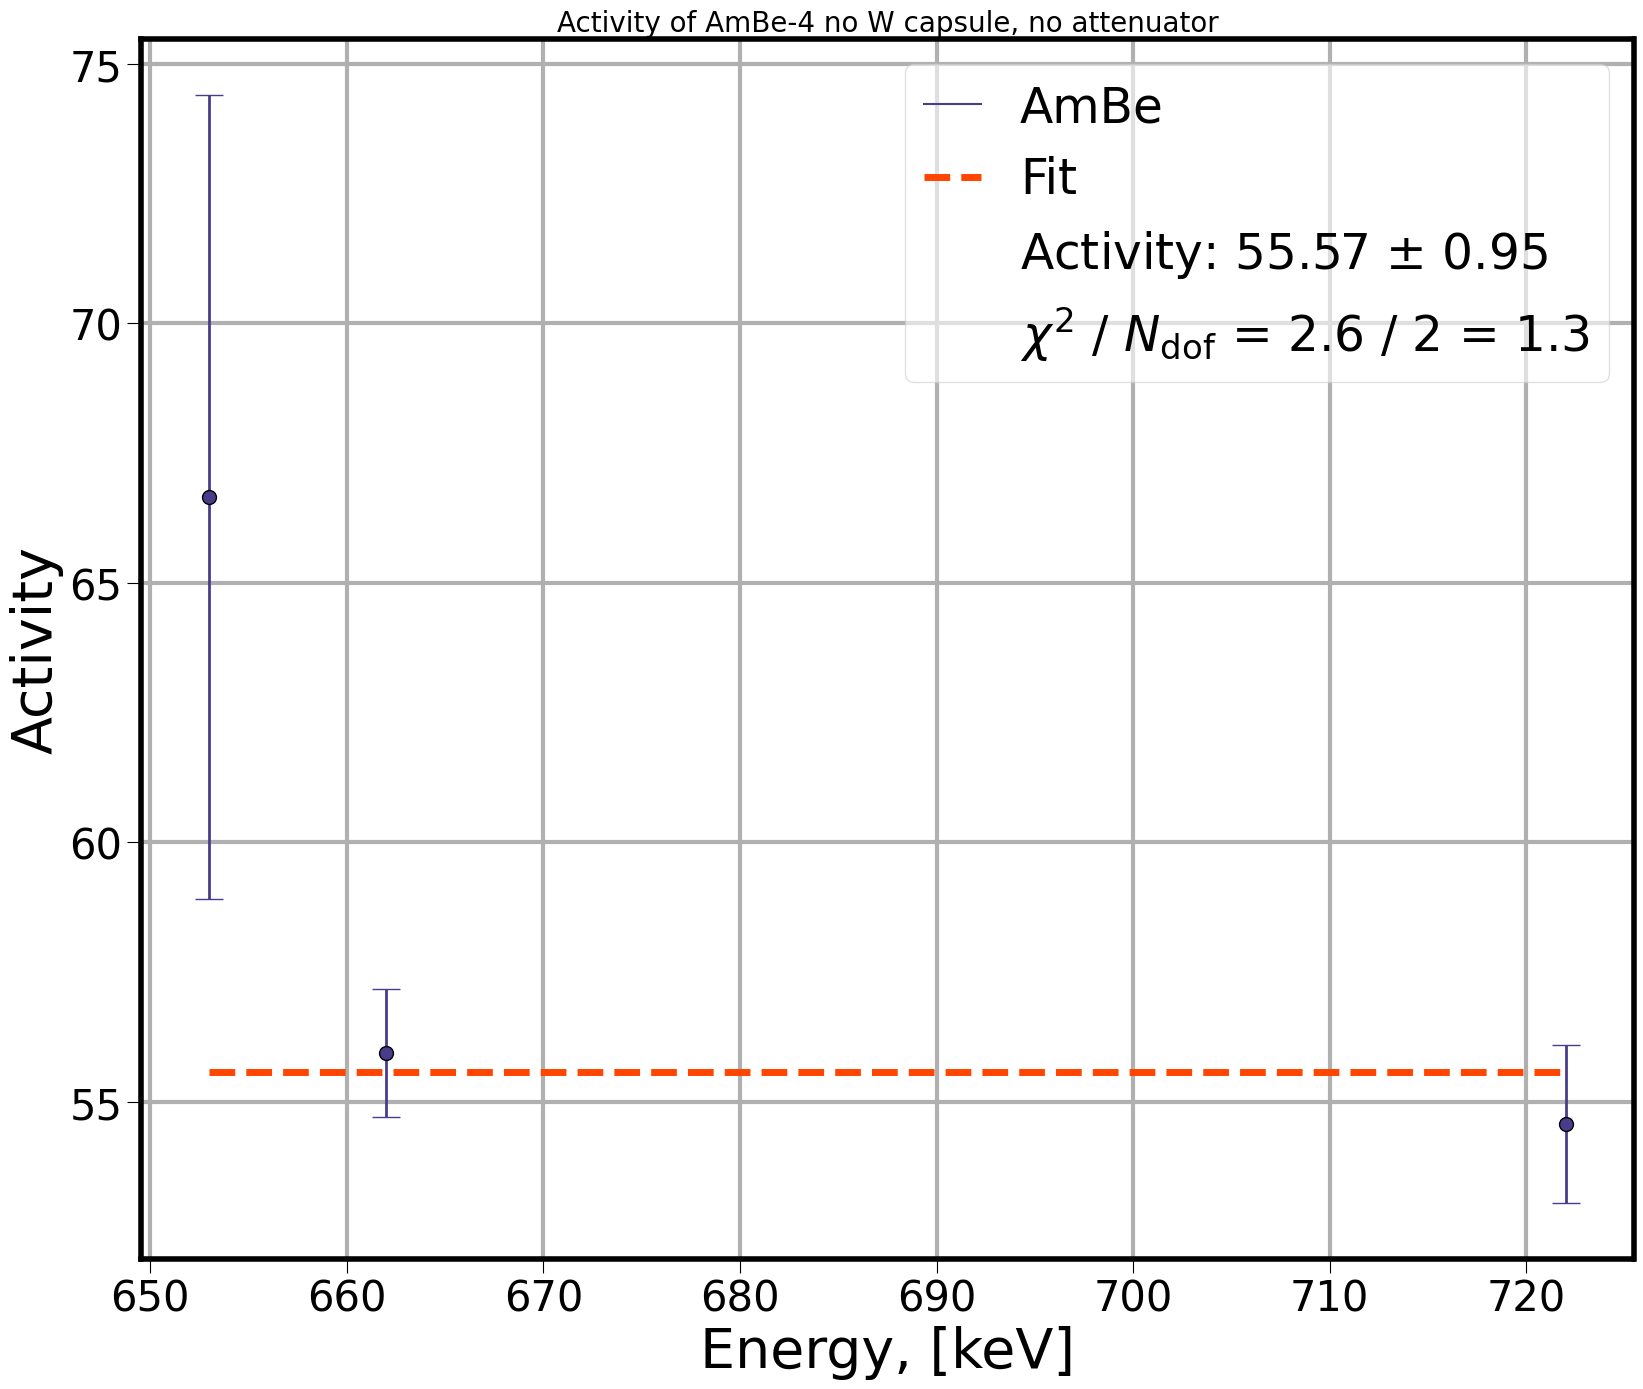

In [13]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('Activity of AmBe-4 no W capsule, no attenuator', fontsize=20)




#label the axes
ax1.set_ylabel( "Activity", fontsize=40)
ax1.set_xlabel( "Energy, [keV]", fontsize=40)


#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)
ax2.tick_params(length=10)

fig.tight_layout()



handlelist=[]
labellist=[]




data_err = plt.errorbar(peak_energy, activity_mean, yerr=np.array(activity_err_mean), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(peak_energy, activity_mean, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def line(x, a, b):
    return a*x+b





#perform a least squares fit with iminuit
least_squares = LeastSquares(peak_energy, activity_mean, activity_err_mean, line)





#set initial parameter values
a00=0
b00=45

#assemble list fit arguments for the minimizer
namelist = ['a', 'b']
kwargs = dict(a=a00, b=b00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
minuit.fixed["a"] = True
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
en = []
enmin=min(peak_energy)
enmax=max(peak_energy)
k=enmin
k_end=enmax

while k<=k_end:
    en.append(k)
    fit.append(line(k, minuit.values['a'], minuit.values['b']))
    k+=0.1


print(enmin)
print(enmax)

Fit, = plt.plot(np.asarray(en), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Activity: {} $\pm$ {}'.format(round(Decimal(minuit.values['b']),number_sigdigs(minuit.errors['b'])), 
                                        round(Decimal(minuit.errors['b']),number_sigdigs(minuit.errors['b'])))


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(activity_mean) - minuit.nfit} = {minuit.fval / (len(activity_mean) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    

leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 35}, loc = 'upper right', fancybox=True, framealpha=0.6)
leg.set_zorder(300)


ax1.grid() # add grid to the plot





#save and show the plot
plt.savefig(measurement_output_path+"Activity.png", bbox_inches ='tight')
plt.show()



<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, 'Gamma spectrum, AmBe-4 with W capsule on endcap, near, with attenuator')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

Text(0.5, 0, 'Energy, [keV]')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 508.2 (χ²/ndof = 1.3)      │              Nfcn = 88               │
│ EDM = 1.06e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  12.53e3  │  0.13e3   │            │            │         │         │       │
│ 1 │ sig    │   44.4    │    0.4    │            │            │         │         │       │
│ 2 │ mu     │ 4.9013e3  │ 0.0005e3  │            │            │         │         │       │
│ 3 │ offset │   6.66    │   0.20    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────┐
│        │       A     sig      mu  offset │
├────────┼─────────────────────────────────┤
│      A │ 1.7e+04   15.60   -0.24   -9.92 │
│    sig │   15.60   0.177   -0.01   -0.03 │
│     mu │   -0.24   -0.01   0.219   -0.00 │
│ offset │   -9.92   -0.03   -0.00  0.0399 │
└────────┴─────────────────────────────────┘

<ValueView A=12525.7491036293 sig=44.37668659131003 mu=4901.25129292875 offset=6.662090563482569>
<ErrorView A=130.27016006024712 sig=0.4209800721262883 mu=0.46769651818599955 offset=0.19966759494571676>
(12525.7491036293, 44.37668659131003, 4901.25129292875, 6.662090563482569)


/tmp/ipykernel_84486/375944578.py:277: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


<Figure size 1700x1400 with 0 Axes>

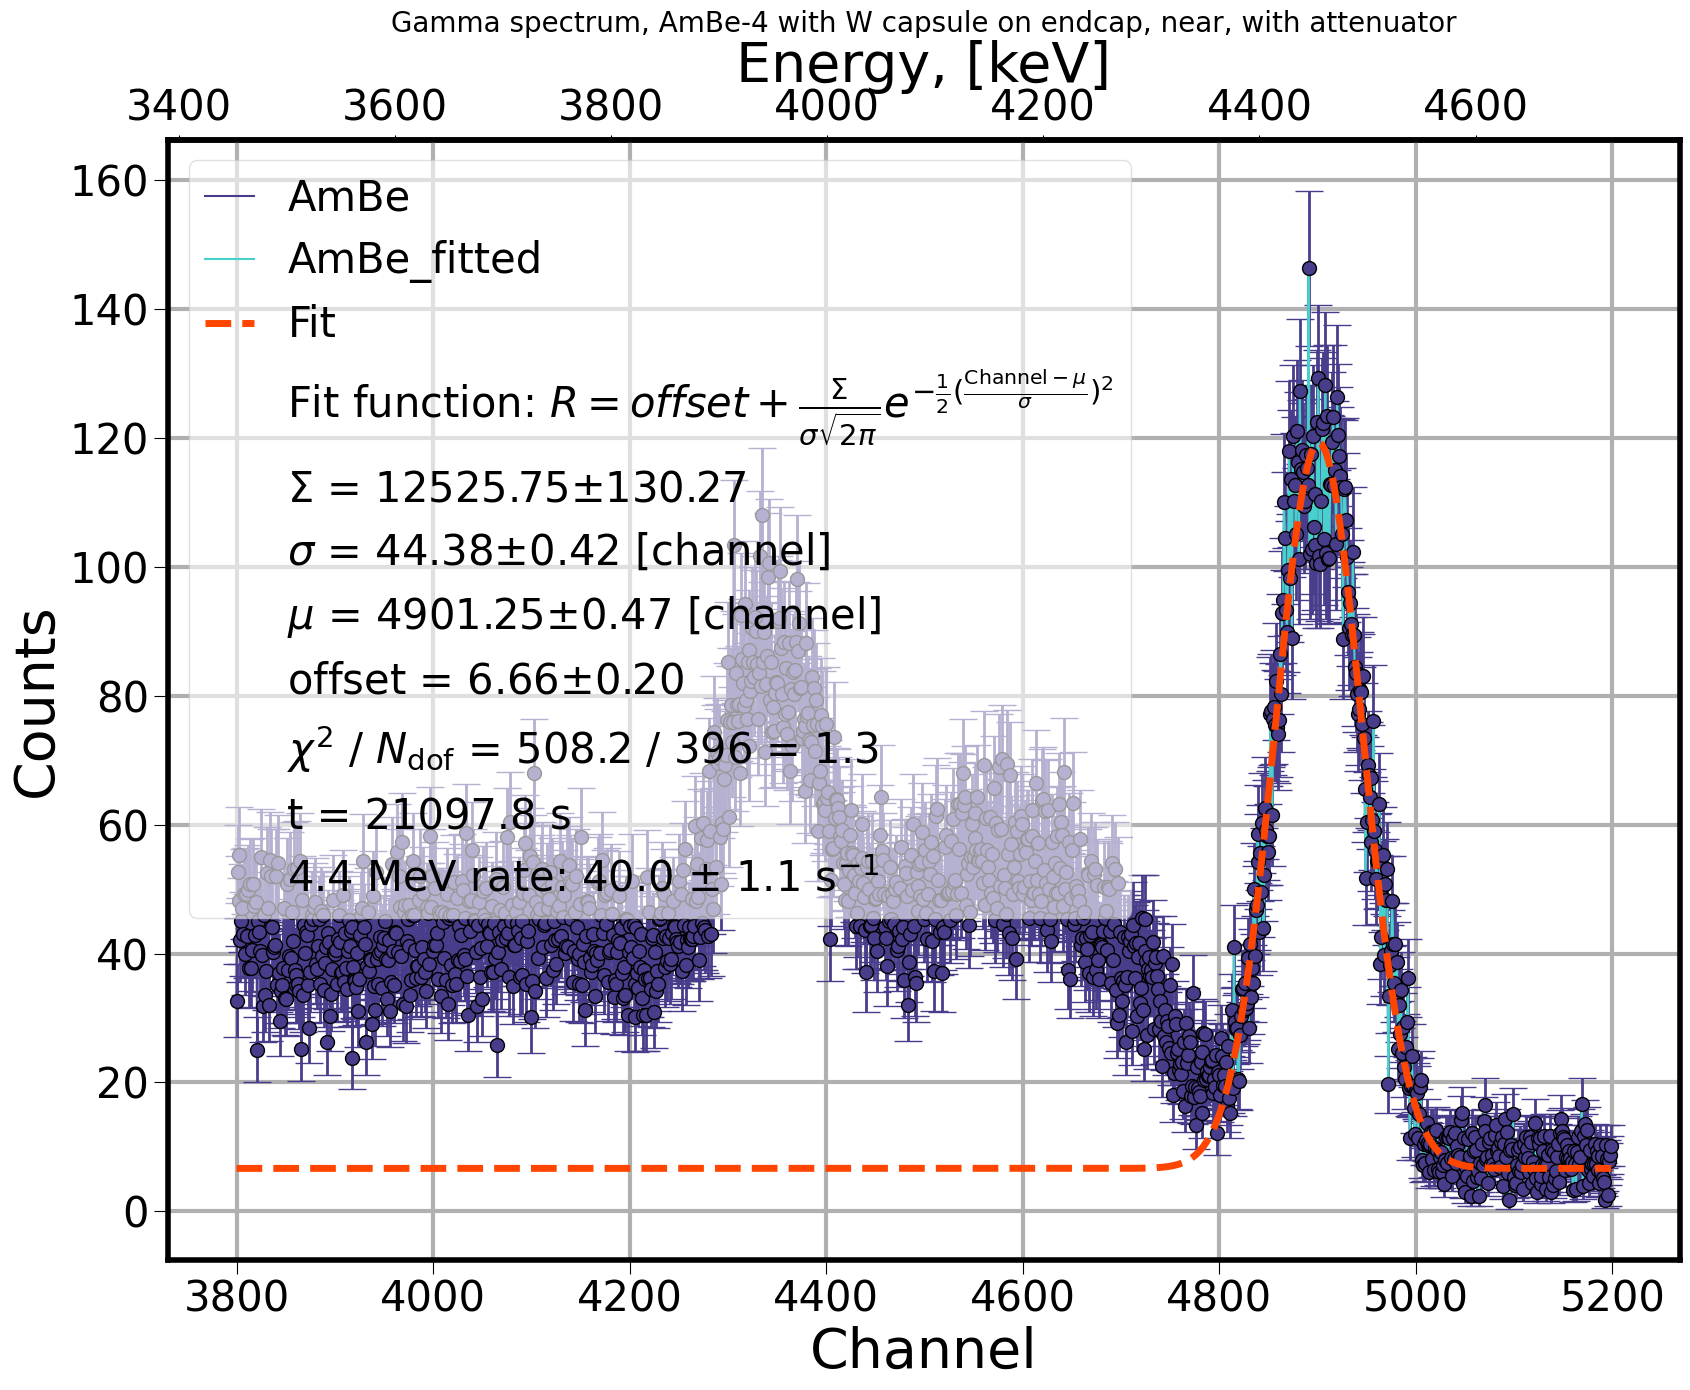

In [14]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares


# Define function and its inverse to make the secons x axis with channels converted to enery
f = lambda x: (x-p0)/p1
g = lambda x: p1*x+p0

plt.figure()
fig, ax1 = plt.subplots()
ax2 = ax1.secondary_xaxis("top", functions=(f,g))

plt.title('Gamma spectrum, AmBe-4 with W capsule on endcap, near, with attenuator', fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)
    
ax2.set_xlabel( "Energy, [keV]", fontsize=40)

for tl in ax2.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)  

    
ax1.tick_params(length=10)

fig.tight_layout()









channels=np.asarray(scan[0][0][3800:5200])
rate_no_bkg=np.asarray(scan[0][1])[3800:5200]-np.asarray(bkg[3800:5200])/t_bkg*t
rate_no_bkg_err=np.sqrt(np.asarray(scan[0][1])[3800:5200]-np.asarray(bkg[3800:5200])/t_bkg*t)

channels_to_fit=np.asarray(scan[0][0][4800:5200])
rate_no_bkg_to_fit=np.asarray(scan[0][1])[4800:5200]-np.asarray(bkg[4800:5200])/t_bkg*t
rate_no_bkg_err_to_fit=np.sqrt(np.asarray(scan[0][1])[4800:5200]-np.asarray(bkg[4800:5200])/t_bkg*t)



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue", label="AmBe",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 10000
mu00 = 4900
sig00 = 45 
offset00 = 6

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
k=chmin
k_end=chmax

while k<=k_end:
    ch.append(k)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(k, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    k+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)




extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}",
      r't'+' = {} s'.format(t),


     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)




efficiency=0.01484 #sigma corrected
efficiency_err=0.00039 #sigma corrected



rate=minuit.values['A']/t/efficiency

rate_err = sqrt((minuit.errors['A']/t/efficiency)**2+(minuit.values['A']*efficiency_err
/t/efficiency**2)**2) #sqrt(np.sum(counts_no_bkg_to_fit))/t/0.00097




handlelist.append(extra)
labellist.append("4.4 MeV rate: {} $\pm$ {}".format(round(Decimal(rate),1), round(Decimal(rate_err),1)) + " s$^{-1}$")
                 







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"Gamma_spectrum_vs_bkg_AmBe-4_withW_withAt_ADC-Ch_fit_4400keV-photopeak_counts.png", bbox_inches ='tight')
plt.show()
